In [ ]:
!pip3 install --upgrade yellowbrick pandas numpy statsmodels

     |████████████████████████████████| 276kB 9.7MB/s 
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.5)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.5)
     |████████████████████████████████| 9.5MB 23.2MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from datetime import datetime
from dateutil.relativedelta import *
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
import matplotlib.pyplot as plt
import yellowbrick
import statsmodels
print('import done')

import done


In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [ ]:
import math

def rmsle(y, y_pred):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [ ]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/kaggle/house_prices_advanced_regression_techniques/'

#設定輸出檔案目錄
figure_dir = groot_dir + 'figure/'
dataroot_dir = groot_dir

gfigure = lambda name: figure_dir + name + '.png' #將來要存的圖形檔案都會在figure_dir目錄下
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300) #輸出圖片
local_time = lambda x, offset: x + relativedelta(hours= offset)

def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('\nData storage points to ==>', groot_dir)
print_now()

Mounted at /content/drive

Running on linux
Python Version 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]

Data storage points to ==> /content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/
2021-02-23 12:10:31.297128


In [ ]:
color = ['#dc2624', '#2b4750', '#45a0a2', '#e87a59','#7dcaa9', '#649E7D', '#dc8018', '#C89F91', '#6c6d6c', '#4f6268', '#c7cccf']
sns.set_palette(color)
sns.set_style('darkgrid',{'axes.facecolor':'#F5F5F5'});

In [ ]:
def start_plot(figsize=(10, 8), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    ax = fig.add_subplot(gs[0,0])
    return ax

#0 讀取資料

In [ ]:
housepricetrain = os.path.join(groot_dir, 'train.csv')
print(housepricetrain) #print路徑
print(os.path.exists(housepricetrain)) #print檔案是否存在

/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/train.csv
True


In [ ]:
housepricetest = os.path.join(groot_dir, 'test.csv')
print(housepricetest) #print路徑
print(os.path.exists(housepricetest)) #print檔案是否存在

/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/test.csv
True


In [ ]:
train = pd.read_csv(housepricetrain)
test = pd.read_csv(housepricetest)

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train.shape

(1460, 81)

In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
test.shape

(1459, 80)

##0.1 整體資料

|index|欄位名稱|非Null|類別|說明|初判重要性|
|:--:|:---|---:|:---:|:---|---:|
|0|Id|1460|類別|就是ID，1~1460||
|1|MSSubClass|1460|類別|住宅類型，幾層樓、什麼年代建造之類的||
|2|MSZoning|1460|類別|分區分類，農業、商業、工業、低密度住宅區、高密度住宅區等等|**|
|3|LotFrontage|1201|數值|連接到地產的線性角(土地對角線的意思嗎)|*|
|4|LotArea|1460|數值|地塊面積||
|5|Street|1460|類別|道路類型||
|6|Alley|91|類別|巷弄類型||
|7|LotShape|1460|類別|地產形狀||
|8|LandContour|1460|類別|土地平整度，就是本身和外界高度是否一致||
|9|Utilities|1460|類別|泛指提供的公共設施及水電煤氣種類，可能全部包含也有只包含水電的。<br>AllPub: All public Utilities (E,G,W,& S)<br>NoSewr: Electricity, Gas, and Water (Septic Tank)<br>NoSeWa: Electricity and Gas Only<br>ELO: Electricity only||
|10|LotConfig|1460|類別|地點配置，像是兩面臨街、三面臨街之類的|*|
|11|LandSlope|1460|類別|坡度，分三個等級||
|12|Neighborhood|1460|類別|Ames city範圍內的實際位置|***|
|13|Condition1|1460|類別|距離主要道路和鐵路的距離||
|14|Condition2|1460|類別|當附近有第二條主要道路和鐵路時，距離該主要道路或者鐵路的距離||
|15|BldgType|1460|類別|住宅的類別||
|16|HouseStyle|1460|類別|住宅的風格||
|17|OverallQual|1460|等級|評估房屋整體材料跟完工品質，1~10評分，5是平均，5以上是正面評價|*****|
|18|OverallCond|1460|等級|評估房屋的整體狀況，1~10評分，5是平均，5以上是正面評價|*****|
|19|YearBuilt|1460|日期|原始施工日期|**|
|20|YearRemodAdd|1460|日期|改造日期，沒改造就跟施工日期相同|***|
|21|RoofStyle|1460|類別|屋頂類型||
|22|RoofMatl|1460|類別|屋頂材料||
|23|Exterior1st|1460|類別|外牆材料(第一種)||
|24|Exterior2nd|1460|類別|外牆材料(第二種)||
|25|MasVnrType|1452|類別|磚類型||
|26|MasVnrArea|1452|數值|用磚面積||
|27|ExterQual|1460|類別|評估外部材料品質，也是評分，分5級||
|28|ExterCond|1460|類別|評估外部材料狀況，也是評分，分5級||
|29|Foundation|1460|類別|地基類型||
|30|BsmtQual|1423|類別|地下室高度|***|
|31|BsmtCond|1423|類別|地下室狀況，也是評分，分5級||
|32|BsmtExposure|1422|類別|步入式地下室或花園地下室的牆壁狀況，也是評分，分5級|**|
|33|BsmtFinType1|1423|類別|地下室完成區域品質，也是評分，分5級||
|34|BsmtFinSF1|1460|數值|Type 1 finished square feet(第一區的面積?)||
|35|BsmtFinType2|1422|類別|第二個地下室完成區域品質，也是評分，分5級(有第二個的話)||
|36|BsmtFinSF2|1460|數值|Type 2 finished square feet(第二區的面積?)||
|37|BsmtUnfSF|1460|數值|未完成的地下室面積||
|38|TotalBsmtSF|1460|數值|地下室面積的平方英尺|**|
|39|Heating|1460|類別|加熱類型，地熱壁爐之類的||
|40|HeatingQC|1460|類別|供熱質量及條件，評分，分5級|*|
|41|CentralAir|1460|類別|中央空調(有或無)|*|
|42|Electrical|1459|類別|電氣系統|*|
|43|1stFlrSF|1460|數值|一樓面積|*|
|44|2ndFlrSF|1460|數值|二樓面積||
|45|LowQualFinSF|1460|數值|所有樓層中，完工品質差的面積||
|46|GrLivArea|1460|數值|地面層以上可居住面積|***|
|47|BsmtFullBath|1460|數值|地下室完整浴室數||
|48|BsmtHalfBath|1460|數值|地下室半套浴室數||
|49|FullBath|1460|數值|地面層以上完整浴室數|*|
|50|HalfBath|1460|數值|地面層以上半套浴室數||
|51|BedroomAbvGr|1460|數值|地面層以上臥室數||
|52|KitchenAbvGr|1460|數值|地面層以上廚房數||
|53|KitchenQual|1460|類別|廚房品質，評分，分5級||
|54|TotRmsAbvGrd|1460|數值|浴室以外的房間總數|***|
|55|Functional|1460|類別|家庭功能評級，有8級，但看不懂各級意思||
|56|Fireplaces|1460|數值|壁爐數量||
|57|FireplaceQu|770|類別|壁爐質量，評分，分5級|***|
|58|GarageType|1379|類別|車庫位置||
|59|GarageYrBlt|1379|日期|車庫建造年份||
|60|GarageFinish|1379|類別|車庫內部裝修程度，評分，分4級||
|61|GarageCars|1460|數值|車庫可容納車輛數|***|
|62|GarageArea|1460|數值|車庫面積|***|
|63|GarageQual|1379|類別|車庫品質，評分，分5級||
|64|GarageCond|1379|類別|車庫條件，評分，分5級||
|65|PavedDrive|1460|類別|車道鋪面，Y有鋪面；P部分鋪面；N髒亂or碎石||
|66|WoodDeckSF|1460|數值|木製甲板面積，木製甲板是三小||
|67|OpenPorchSF|1460|數值|開放式陽台面積||
|68|EnclosedPorch|1460|數值|封閉是陽台面積||
|69|3SsnPorch|1460|數值|Three season porch(某種陽台)面積||
|70|ScreenPorch|1460|數值|Screen porch(某種陽台)面積||
|71|PoolArea|1460|數值|泳池面積||
|72|PoolQC|7|類別|泳池品質，評分，分5級|***|
|73|Fence|281|類別|圍欄品持，評分，分5級||
|74|MiscFeature|54|類別|雜項功能，像是電梯、第二個車庫、網球場之類的||
|75|MiscVal|1460|數值|雜項功能的價值$$$|*|
|76|MoSold|1460|數值|銷售月(MM)||
|77|YrSold|1460|數值|銷售年(YYYY)||
|78|SaleType|1460|類別|銷售類型||
|79|SaleCondition|1460|類別|銷售條件||
|80|SalePrice|1460|數值|預測金額，就是y||

In [ ]:
train.drop(['Id'], axis=1).describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
test.drop(['Id'], axis=1).describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


##0.2 缺失值

###0.2.1 Train

In [ ]:
nullsum = pd.DataFrame()
x = []
y = []
for colname in train.columns:
  x.append(colname)
  y.append(train[colname].isnull().sum())

nullsum['columns'] = x
nullsum['nullvalue'] = y

nullsum[nullsum['nullvalue']>0]

,columns,nullvalue
3,LotFrontage,259
6,Alley,1369
25,MasVnrType,8
26,MasVnrArea,8
30,BsmtQual,37
31,BsmtCond,37
32,BsmtExposure,38
33,BsmtFinType1,37
35,BsmtFinType2,38
42,Electrical,1


###0.2.2 Test

In [ ]:
nullsum_test = pd.DataFrame()
x = []
y = []
for colname in test.columns:
  x.append(colname)
  y.append(test[colname].isnull().sum())

nullsum_test['columns'] = x
nullsum_test['nullvalue'] = y

nullsum_test[nullsum_test['nullvalue']>0]

,columns,nullvalue
2,MSZoning,4
3,LotFrontage,227
6,Alley,1352
9,Utilities,2
23,Exterior1st,1
24,Exterior2nd,1
25,MasVnrType,16
26,MasVnrArea,15
30,BsmtQual,44
31,BsmtCond,45


##0.3 資料分布

In [ ]:
out = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index
train.drop(out, inplace=True)

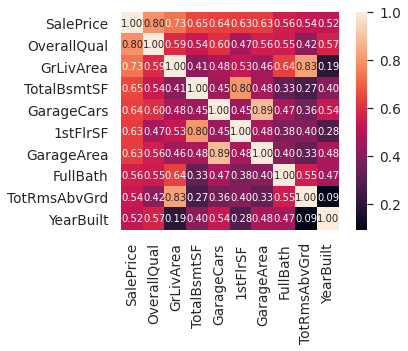

In [ ]:
corrmatrix = train.corr()
cols = corrmatrix.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [ ]:
def box(columnname):
  fig,ax = plt.subplots(figsize=(8,5))
  sns.boxplot(ax=ax, x=columnname, y='SalePrice', data=train, order=train.groupby(columnname)['SalePrice'].mean().sort_values(ascending=False).index)
  ax.axis(ymin=0, ymax=800000);
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

def scatter(columnname):
  fig,ax = plt.subplots(figsize=(8,5))
  sns.scatterplot(ax=ax, x=columnname, y='SalePrice', data=train)
  ax.axis(ymin=0, ymax=800000);

64 GarageCond、58 GarageType、59 GarageYrBlt、60 GarageFinish、63 GarageQual 沒有就是沒車庫\
32 BsmtExposure、35 BsmtFinType2、31 BsmtCond、30 BsmtQual、33 BsmtFinType1 沒有就當沒地下室\
57 FireplaceQu 沒有就是沒壁爐\
6 Alley 就沒巷道\
26 MasVnrArea、25 MasVnrType 沒有就補0

In [ ]:
print(train['Exterior1st'].isnull().sum())
print(test['Exterior1st'].isnull().sum())

0
1


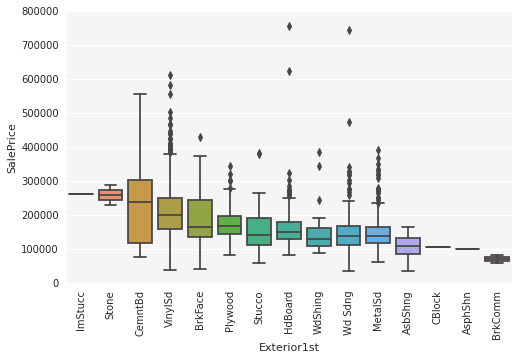

In [ ]:
box('Exterior1st')

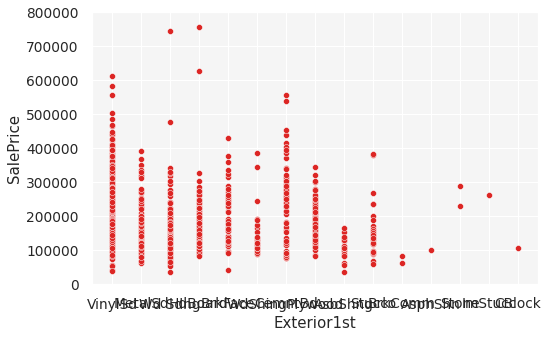

In [ ]:
scatter('Exterior1st')

In [ ]:
train.groupby('Exterior1st')['SalePrice'].describe().sort_values(by=['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
Exterior1st,,,,,,,,
ImStucc,1.0,262000.000000,NaN,262000.0,262000.0,262000.0,262000.00,262000.0
Stone,2.0,258500.000000,40305.086528,230000.0,244250.0,258500.0,272750.00,287000.0
CemntBd,60.0,232473.000000,121436.925001,75000.0,118375.0,238750.0,304082.75,556581.0
VinylSd,515.0,213732.900971,80646.975785,37900.0,160000.0,200000.0,248614.00,611657.0
BrkFace,50.0,194573.000000,82841.914370,40000.0,134525.0,165750.0,245125.00,430000.0
Plywood,108.0,175942.379630,49497.383293,82500.0,143437.5,167450.0,197500.00,345000.0
Stucco,24.0,163114.583333,85096.626198,58500.0,111500.0,142000.0,191550.00,381000.0
HdBoard,222.0,163077.450450,66305.714164,83000.0,129625.0,149900.0,179900.00,755000.0
WdShing,26.0,150655.076923,72507.530741,87000.0,109750.0,128700.0,160250.00,385000.0


In [ ]:
train['Exterior1st'].unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

#1 測試1 (Score: 0.15556)

##1.1 定義特徵工程

In [ ]:
def cleanfeature(data):
  #補缺失值
  for i in ['PoolQC','FireplaceQu','BsmtExposure']:
    data[i] = data[i].fillna('None', inplace=True)

  data['Electrical'].fillna('SBrkr', inplace=True)
  data['MSZoning'].fillna('RL', inplace=True)
  data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)
  data['BsmtQual'].fillna(0, inplace=True)
  
  #取log
  tmp = []
  for i in data.index:
    if data.loc[i,'LotFrontage']>0:
      tmp.append(np.log(data.loc[i,'LotFrontage']))
    else:
      tmp.append(0)
  data['LotFrontage_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'1stFlrSF']>0:
      tmp.append(np.log(data.loc[i,'1stFlrSF']))
    else:
      tmp.append(0)
  data['1stFlrSF_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'TotalBsmtSF']>0:
      tmp.append(np.log(data.loc[i,'TotalBsmtSF']))
    else:
      tmp.append(0)
  data['TotalBsmtSF_log'] = tmp
  
  #新欄位
  data['CarArea'] = data['GarageCars']/data['GarageArea']
  data['CarArea'].fillna(0, inplace=True)
  data['RoomArea'] = data['GrLivArea']/data['TotRmsAbvGrd']
  data['RoomArea'].fillna(0, inplace=True)

  #數值轉類別
  data['OverallCond'].replace({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'},inplace=True)
  
  #挑出欄位
  choose = ['PoolQC','FireplaceQu','BsmtExposure','MSZoning','Neighborhood','OverallQual','OverallCond','HeatingQC','CentralAir',
  'LotFrontage_log','BsmtQual','YearRemodAdd','1stFlrSF_log','FullBath','CarArea','RoomArea']
  newdata = data.loc[:,choose]
  newdata = pd.get_dummies(newdata,drop_first=True)
  return newdata

In [ ]:
train['SalePrice_log'] = np.log(train['SalePrice'])
train2 = cleanfeature(train)
train2['SalePrice_log'] = train['SalePrice_log']
print(train2.isnull().sum()[train2.isnull().sum()!=0])

Series([], dtype: int64)


In [ ]:
train2.head()

,OverallQual,LotFrontage_log,YearRemodAdd,1stFlrSF_log,FullBath,CarArea,RoomArea,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallCond_five,OverallCond_four,OverallCond_nine,OverallCond_one,OverallCond_seven,OverallCond_six,OverallCond_three,OverallCond_two,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,SalePrice_log
0,7,4.174387,2003,6.752270,2,0.003650,213.750000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,12.247694
1,6,4.382027,1976,7.140453,2,0.004348,210.333333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,12.109011
2,7,4.219508,2002,6.824374,2,0.003289,297.666667,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,12.317167
3,7,4.094345,1970,6.867974,1,0.004673,245.285714,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,11.849398
4,8,4.430817,2000,7.043160,2,0.003589,244.222222,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,12.429216


In [ ]:
X_realtest = cleanfeature(test)
print(X_realtest.isnull().sum()[X_realtest.isnull().sum()!=0])

Series([], dtype: int64)


In [ ]:
X_realtest.head()

,OverallQual,LotFrontage_log,YearRemodAdd,1stFlrSF_log,FullBath,CarArea,RoomArea,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallCond_five,OverallCond_four,OverallCond_nine,OverallCond_one,OverallCond_seven,OverallCond_six,OverallCond_three,OverallCond_two,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA
0,5,4.382027,1961,6.797940,1,0.001370,179.200000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1
1,6,4.394449,1958,7.192182,1,0.003205,221.500000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1
2,5,4.304065,1998,6.833032,2,0.004149,271.500000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3,6,4.356709,1998,6.830874,2,0.004255,229.142857,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
4,8,3.761200,1992,7.154615,2,0.003953,256.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


##1.2 Train資料嘗試建模

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline( StandardScaler(),PCA(n_components=50),Ridge(alpha=0.5) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.8615339990645866
Root Mean Squared Logarithmic Error: 0.01188842720640183
 
5fold-CV R-squared: [0.86742353 0.84241031 0.83278688 0.85360445 0.81194224]
5fold-CV R-squared Avg: 0.8416334826784541
5fold-CV R-squared Std: 0.018808861727960677


##1.3 預測Test資料集

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

model = make_pipeline( StandardScaler(),PCA(n_components=50),Ridge(alpha=0.5) )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)
y_pred

array([116871.3535365 , 156087.03411706, 167048.19268936, ...,
       158887.50074006, 113419.24460874, 184099.22197522])

In [ ]:
submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,116871.353537
1,1462,156087.034117
2,1463,167048.192689
3,1464,187826.841010
4,1465,252166.715727


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/Ridge_PCA_logy.csv',index=False)

這次成績0.15556，但還是跟上面估的差好多喔QQ

#2 測試2 (Score: 0.15094)

##2.1 特徵工程調整

###2.1.1 排除離群值

In [ ]:
out = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index
out

Int64Index([523, 1298], dtype='int64')

In [ ]:
print(train.shape)
#排除離群值
train.drop(out, inplace=True)
print(train.shape)

(1460, 81)
(1458, 81)


###2.1.2  定義特徵工程

In [ ]:
def cleanfeature(data):
  #缺失值補None #新增Alley、FireplaceQu、GarageQual
  for i in ['PoolQC','FireplaceQu','BsmtExposure','Alley','FireplaceQu','GarageQual']:
    data[i] = data[i].fillna('None', inplace=True)
  
  #其他補缺失值
  data['Electrical'].fillna('SBrkr', inplace=True)
  data['MSZoning'].fillna('RL', inplace=True)
  data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)

  #缺失值補0 #新增MasVnrArea
  for i in ['BsmtQual','MasVnrArea']:
    data[i] = data[i].fillna(0, inplace=True)

  
  #取log
  tmp = []
  for i in data.index:
    if data.loc[i,'LotFrontage']>0:
      tmp.append(np.log(data.loc[i,'LotFrontage']))
    else:
      tmp.append(0)
  data['LotFrontage_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'1stFlrSF']>0:
      tmp.append(np.log(data.loc[i,'1stFlrSF']))
    else:
      tmp.append(0)
  data['1stFlrSF_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'TotalBsmtSF']>0:
      tmp.append(np.log(data.loc[i,'TotalBsmtSF']))
    else:
      tmp.append(0)
  data['TotalBsmtSF_log'] = tmp
  
  #新欄位
  data['CarArea'] = data['GarageCars']/data['GarageArea']
  data['CarArea'].fillna(0, inplace=True)
  data['RoomArea'] = data['GrLivArea']/data['TotRmsAbvGrd']
  data['RoomArea'].fillna(0, inplace=True)

  #數值轉類別 #新增MSSubClass
  data['OverallCond'].replace({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'},inplace=True)
  #train資料沒有150這類，看類別覺得150和75蠻接近的，先把它和75放同一類
  data['MSSubClass'].replace({20:'one',30:'two',40:'three',45:'four',50:'five',60:'six',70:'seven',75:'eight',80:'nine',85:'ten',90:'eleven',120:'twelve',150:'eight',160:'fourteen',180:'fifteen',190:'sixteen'},inplace=True)

  #挑出欄位 #新增Neighborhood
  choose = ['PoolQC','FireplaceQu','BsmtExposure','MSZoning','Neighborhood','OverallQual','OverallCond','HeatingQC','CentralAir',
  'LotFrontage_log','BsmtQual','YearRemodAdd','1stFlrSF_log','FullBath','CarArea','RoomArea','Alley','FireplaceQu','GarageQual',
  'MSSubClass','Neighborhood']
  newdata = data.loc[:,choose]
  newdata = pd.get_dummies(newdata,drop_first=True)
  return newdata

In [ ]:
train['SalePrice_log'] = np.log(train['SalePrice'])
train2 = cleanfeature(train)
train2['SalePrice_log'] = train['SalePrice_log']
print(train2.isnull().sum()[train2.isnull().sum()!=0])
train2.head()

Series([], dtype: int64)


,OverallQual,LotFrontage_log,YearRemodAdd,1stFlrSF_log,FullBath,CarArea,RoomArea,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallCond_five,OverallCond_four,OverallCond_nine,OverallCond_one,OverallCond_seven,...,CentralAir_Y,MSSubClass_eleven,MSSubClass_fifteen,MSSubClass_five,MSSubClass_four,MSSubClass_fourteen,MSSubClass_nine,MSSubClass_one,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SalePrice_log
0,7,4.174387,2003,6.752270,2,0.003650,213.750000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.247694
1,6,4.382027,1976,7.140453,2,0.004348,210.333333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,12.109011
2,7,4.219508,2002,6.824374,2,0.003289,297.666667,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.317167
3,7,4.094345,1970,6.867974,1,0.004673,245.285714,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.849398
4,8,4.430817,2000,7.043160,2,0.003589,244.222222,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,12.429216


In [ ]:
train2.shape

(1458, 87)

In [ ]:
X_realtest = cleanfeature(test)
print(X_realtest.isnull().sum()[X_realtest.isnull().sum()!=0])
X_realtest.head()

Series([], dtype: int64)


,OverallQual,LotFrontage_log,YearRemodAdd,1stFlrSF_log,FullBath,CarArea,RoomArea,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallCond_five,OverallCond_four,OverallCond_nine,OverallCond_one,OverallCond_seven,...,HeatingQC_TA,CentralAir_Y,MSSubClass_eleven,MSSubClass_fifteen,MSSubClass_five,MSSubClass_four,MSSubClass_fourteen,MSSubClass_nine,MSSubClass_one,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,5,4.382027,1961,6.797940,1,0.001370,179.200000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,6,4.394449,1958,7.192182,1,0.003205,221.500000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,5,4.304065,1998,6.833032,2,0.004149,271.500000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,4.356709,1998,6.830874,2,0.004255,229.142857,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,3.761200,1992,7.154615,2,0.003953,256.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
X_realtest.shape

(1459, 86)

##2.2 Train資料嘗試建模

###2.2.1 想想怎麼調整參數

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

86


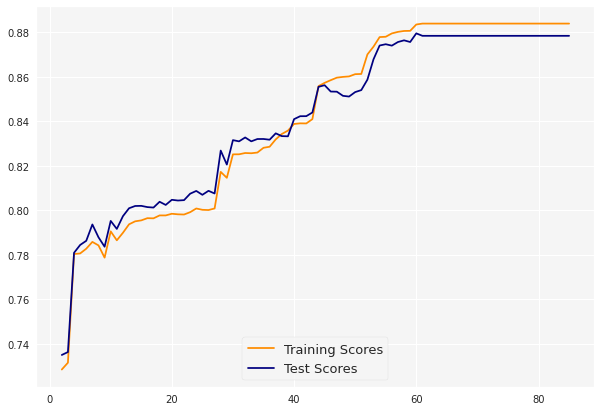

In [ ]:
N = len(train2.columns)-1 #原始成分數量
print(N)
scores_train = np.zeros(N)
scores_test = np.zeros(N)

for i in np.arange(N,2,-1): #從N遞減到2，
  model = make_pipeline(
      StandardScaler(),
      PCA(n_components=i),
      Ridge(alpha=1)
  )
  model.fit(X_train,y_train)
  scores_train[i-1] = model.score(X_train,y_train) #也可以換成其他想用的score
  scores_test[i-1] = model.score(X_test,y_test)

def start_plot(figsize=(10, 8), style = 'whitegrid'):
  fig = plt.figure(figsize=figsize)
  gs = fig.add_gridspec(1,1)
  plt.tight_layout()
  ax = fig.add_subplot(gs[0,0])
  return ax

xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(10,7))
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores')
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores')
ax.legend(loc='lower center',frameon=True,fontsize=13)

[0.011885910747876111, 0.011811553796088626, 0.011776562048699205, 0.011613034470397025, 0.011227927966187502, 0.01095834278688485, 0.010929945894609794, 0.010961071652768876, 0.010887803439753723, 0.010854691792632123, 0.010886076023531904, 0.010686511403308662, 0.010729995562049503, 0.0107299955620495, 0.010729995562049495]


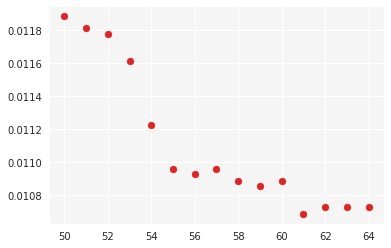

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

rmsle_score=[]
components=[i for i in range(50,65)]

for n in components:
    model = make_pipeline( StandardScaler(),PCA(n_components=n),Ridge(alpha=2) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
plt.scatter(components, rmsle_score)

[0.010689623621839815, 0.010689481725981782, 0.010689310211073711, 0.010688833414227591, 0.010688156967102406, 0.010687615548825831, 0.0106871958210049, 0.0106868857995423, 0.01068667470361846, 0.010686552823309273, 0.010686511403308658, 0.010686542540600471, 0.010686639094238904, 0.010686794605662218, 0.010687003228187459, 0.01068725966452396, 0.010687559111304111, 0.010687897209765203, 0.010688270001834577, 0.010690040889266896]


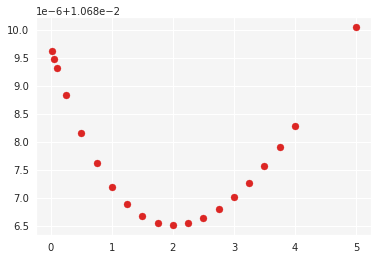

In [ ]:
rmsle_score=[]
alpha=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3,
    3.25, 3.5, 3.75, 4, 5]

for a in alpha:
    model = make_pipeline( StandardScaler(),PCA(n_components=61),Ridge(alpha=a) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
plt.scatter(alpha, rmsle_score)

###2.2.2 建模

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline( StandardScaler(),PCA(n_components=61),Ridge(alpha=2) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.8794981737855949
Root Mean Squared Logarithmic Error: 0.010686511403308655
 
5fold-CV R-squared: [0.88731107 0.88294178 0.86389702 0.86763646 0.8656141 ]
5fold-CV R-squared Avg: 0.8734800838367367
5fold-CV R-squared Std: 0.009681700192818048


##2.3 預測Test資料集

發現train資料沒有150這類，回頭改特徵處理

In [ ]:
traincol = list(train2.drop('SalePrice_log', axis = 1).columns)
testcol = list(X_realtest.columns)
col_diff = list(set(testcol).difference(set(traincol)))
col_diff

['MSSubClass_thirteen']

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

model = make_pipeline( StandardScaler(),PCA(n_components=61),Ridge(alpha=2) )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)
y_pred

array([116488.28438875, 156547.25469624, 173746.56077213, ...,
       162181.3148321 , 127170.16973024, 211148.06340451])

In [ ]:
submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,116488.284389
1,1462,156547.254696
2,1463,173746.560772
3,1464,197922.375856
4,1465,239111.194477


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/Ridge_PCA_logy2.csv',index=False)

# 3 測試3 (Score: 0.15053)

##3.1 特徵工程調整

###3.1.1 排除離群值

In [ ]:
out = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index
out

Int64Index([523, 1298], dtype='int64')

In [ ]:
print(train.shape)
#排除離群值
train.drop(out, inplace=True)
print(train.shape)

(1460, 81)
(1458, 81)


###3.1.2 定義特徵工程

In [ ]:
def cleanfeature(data):
  #缺失值補None
  for i in ['PoolQC','FireplaceQu','BsmtExposure','Alley','FireplaceQu','GarageQual']:
    data[i] = data[i].fillna('None', inplace=True)

  #其他補缺失值
  data['Electrical'].fillna('SBrkr', inplace=True)
  data['MSZoning'].fillna('RL', inplace=True)
  data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)

  #缺失值補0
  for i in ['BsmtQual','MasVnrArea']:
    data[i] = data[i].fillna(0, inplace=True)

  
  #取log
  tmp = []
  for i in data.index:
    if data.loc[i,'LotFrontage']>0:
      tmp.append(np.log(data.loc[i,'LotFrontage']))
    else:
      tmp.append(0)
  data['LotFrontage_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'1stFlrSF']>0:
      tmp.append(np.log(data.loc[i,'1stFlrSF']))
    else:
      tmp.append(0)
  data['1stFlrSF_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'TotalBsmtSF']>0:
      tmp.append(np.log(data.loc[i,'TotalBsmtSF']))
    else:
      tmp.append(0)
  data['TotalBsmtSF_log'] = tmp
  
  #新欄位
  data['CarArea'] = data['GarageCars']/data['GarageArea']
  data['CarArea'].fillna(0, inplace=True)
  data['RoomArea'] = data['GrLivArea']/data['TotRmsAbvGrd']
  data['RoomArea'].fillna(0, inplace=True)

  #數值轉類別
  data['OverallCond'].replace({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'},inplace=True)
  #train資料沒有150這類，看類別覺得150和75蠻接近的，先把它和75放同一類
  data['MSSubClass'].replace({20:'one',30:'two',40:'three',45:'four',50:'five',60:'six',70:'seven',75:'eight',80:'nine',85:'ten',90:'eleven',120:'twelve',150:'eight',160:'fourteen',180:'fifteen',190:'sixteen'},inplace=True)

  #挑出欄位
  choose = ['PoolQC','FireplaceQu','BsmtExposure','MSZoning','Neighborhood','OverallQual','OverallCond','HeatingQC','CentralAir',
  'LotFrontage_log','BsmtQual','YearRemodAdd','1stFlrSF_log','FullBath','CarArea','RoomArea','Alley','FireplaceQu','GarageQual',
  'MSSubClass']
  newdata = data.loc[:,choose]
  newdata = pd.get_dummies(newdata,drop_first=True)
  return newdata

In [ ]:
train['SalePrice_log'] = np.log(train['SalePrice'])
train2 = cleanfeature(train)
train2['SalePrice_log'] = train['SalePrice_log']
print(train2.isnull().sum()[train2.isnull().sum()!=0])
train2.head()

Series([], dtype: int64)


,OverallQual,LotFrontage_log,YearRemodAdd,1stFlrSF_log,FullBath,CarArea,RoomArea,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallCond_five,OverallCond_four,OverallCond_nine,OverallCond_one,OverallCond_seven,...,CentralAir_Y,MSSubClass_eleven,MSSubClass_fifteen,MSSubClass_five,MSSubClass_four,MSSubClass_fourteen,MSSubClass_nine,MSSubClass_one,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SalePrice_log
0,7,4.174387,2003,6.752270,2,0.003650,213.750000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.247694
1,6,4.382027,1976,7.140453,2,0.004348,210.333333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,12.109011
2,7,4.219508,2002,6.824374,2,0.003289,297.666667,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.317167
3,7,4.094345,1970,6.867974,1,0.004673,245.285714,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.849398
4,8,4.430817,2000,7.043160,2,0.003589,244.222222,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,12.429216


In [ ]:
a = train2.columns

In [ ]:
X_realtest = cleanfeature(test)
print(X_realtest.isnull().sum()[X_realtest.isnull().sum()!=0])
X_realtest.head()

Series([], dtype: int64)


,OverallQual,LotFrontage_log,YearRemodAdd,1stFlrSF_log,FullBath,CarArea,RoomArea,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallCond_five,OverallCond_four,OverallCond_nine,OverallCond_one,OverallCond_seven,...,HeatingQC_TA,CentralAir_Y,MSSubClass_eleven,MSSubClass_fifteen,MSSubClass_five,MSSubClass_four,MSSubClass_fourteen,MSSubClass_nine,MSSubClass_one,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,5,4.382027,1961,6.797940,1,0.001370,179.200000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,6,4.394449,1958,7.192182,1,0.003205,221.500000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,5,4.304065,1998,6.833032,2,0.004149,271.500000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,4.356709,1998,6.830874,2,0.004255,229.142857,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,3.761200,1992,7.154615,2,0.003953,256.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


##3.2 Train資料嘗試建模
可能還有很多沒撈出來的離群值(懶得撈了)，改用RobustScaler()減少離群值影響

###3.2.1 調整模型

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

86


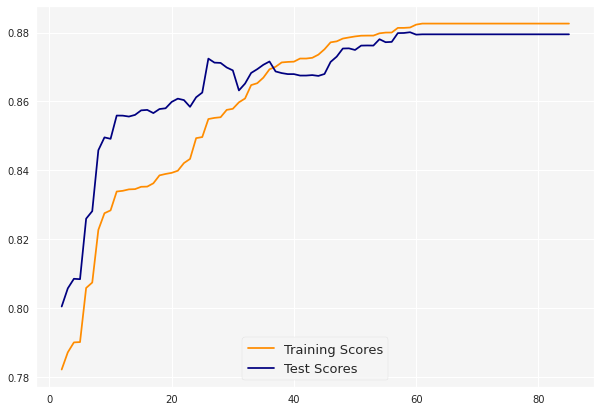

In [ ]:
N = len(train2.columns)-1 #原始成分數量
print(N)
scores_train = np.zeros(N)
scores_test = np.zeros(N)

for i in np.arange(N,2,-1): #從N遞減到2，
  model = make_pipeline(
      RobustScaler(),
      PCA(n_components=i),
      Ridge(alpha=1)
  )
  model.fit(X_train,y_train)
  scores_train[i-1] = model.score(X_train,y_train) #也可以換成其他想用的score
  scores_test[i-1] = model.score(X_test,y_test)

def start_plot(figsize=(10, 8), style = 'whitegrid'):
  fig = plt.figure(figsize=figsize)
  gs = fig.add_gridspec(1,1)
  plt.tight_layout()
  ax = fig.add_subplot(gs[0,0])
  return ax

xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(10,7))
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores')
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores')
ax.legend(loc='lower center',frameon=True,fontsize=13)

[0.010916970923020436, 0.010944731769596386, 0.010883066222204911, 0.0108814569883502, 0.01088311093536982, 0.010779784314885165, 0.010833430679902315, 0.010828375951202448, 0.010645217634451086, 0.010642403231411642, 0.010625215271222309, 0.010721780007718477, 0.010732445634620306, 0.010732445634620308, 0.010732445634620311]


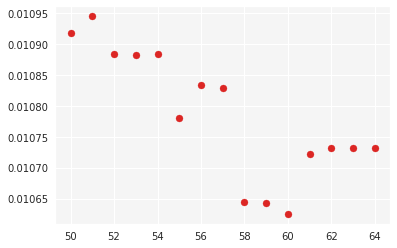

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

rmsle_score=[]
components=[i for i in range(50,65)]

for n in components:
    model = make_pipeline( RobustScaler(),PCA(n_components=n),Ridge(alpha=0.05) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
plt.scatter(components, rmsle_score)

[0.010728762328448103, 0.010721780007718468, 0.010714983949289575, 0.010703142516466337, 0.010697700819440987, 0.01069901799055179, 0.010702451740896403, 0.010706393165926776, 0.010710255193833777, 0.010713833527449262, 0.010717075525399343, 0.010719989101838662, 0.010722604812537164, 0.01072495966867044, 0.01072709029020786, 0.010729030202535256, 0.01073080899126951, 0.010732452276490742, 0.010733982024960209, 0.010739301022170114]


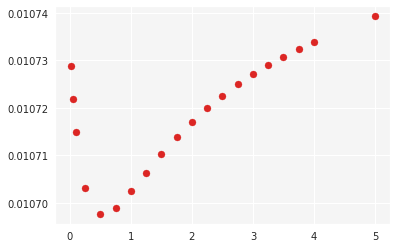

In [ ]:
rmsle_score=[]
alpha=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3,
    3.25, 3.5, 3.75, 4, 5]

for a in alpha:
    model = make_pipeline( RobustScaler(),PCA(n_components=61),Ridge(alpha=a) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
plt.scatter(alpha, rmsle_score)

###3.2.2 建模

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline( RobustScaler(),PCA(n_components=61),Ridge(alpha=0.5) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.8793857709295715
Root Mean Squared Logarithmic Error: 0.010697700819440997
 
5fold-CV R-squared: [0.88631538 0.88204133 0.86304492 0.86763152 0.86630058]
5fold-CV R-squared Avg: 0.8730667471301731
5fold-CV R-squared Std: 0.009293322641139353


測試看看，但這樣好像沒比較好耶，我還是直接make pipeline好了><

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = make_pipeline( PCA(n_components=61),Ridge(alpha=0.5) )
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print('R-squared:',model.score(X_test_scaled, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.8793857709295717
Root Mean Squared Logarithmic Error: 0.010697700819440983
 
5fold-CV R-squared: [0.88866106 0.87944458 0.86327515 0.86690064 0.86256535]
5fold-CV R-squared Avg: 0.8721693571828775
5fold-CV R-squared Std: 0.010237269100802257


##3.3 預測Test資料集

檢查Train和Test欄位有沒有不同

In [ ]:
traincol = list(train2.drop('SalePrice_log', axis = 1).columns)
testcol = list(X_realtest.columns)
col_diff = list(set(testcol).difference(set(traincol)))
col_diff

[]

In [ ]:
col_diff = list(set(traincol).difference(set(testcol)))
col_diff

[]

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

model = make_pipeline( RobustScaler(),PCA(n_components=61),Ridge(alpha=0.5) )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)
y_pred

array([115431.66534902, 156585.30252634, 173513.13501559, ...,
       162092.64821038, 127036.64748575, 211215.74030788])

In [ ]:
submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,115431.665349
1,1462,156585.302526
2,1463,173513.135016
3,1464,197879.846306
4,1465,238433.852059


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/RobustScaler_PCA_Ridge_logy.csv',index=False)

#4 測試4 (Score: 0.14640)

##4.1 特徵工程調整

###4.1.1 排除離群值

In [ ]:
train = pd.read_csv(housepricetrain)
test = pd.read_csv(housepricetest)

In [ ]:
out = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index
print(out)
print(train.shape)
#排除離群值
train.drop(out, inplace=True)
print(train.shape)

Int64Index([523, 1298], dtype='int64')
(1460, 81)
(1458, 81)


###4.1.2 定義特徵工程

這次才發現之前補缺失值的部分有bug QQ\
然後發現前面補None的那些欄位...效果蠻差的哈哈哈，測來測去還是先拿掉好了\
再仔細看看要怎麼分類

In [ ]:
def cleanfeature(data):
  #缺失值補None
  #"MiscFeature", "Fence", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType"
  #"BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"
  #for i in ['PoolQC','FireplaceQu','BsmtExposure','Alley','FireplaceQu','GarageQual']:
    #data[i].fillna('NoData', inplace=True)
  
  #補眾數
  #"MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional"
  #"Electrical", "KitchenQual", "SaleType", "Exterior1st", "Exterior2nd"

  #其他補缺失值
  data['MSZoning'].fillna('RL', inplace=True)
  data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)

  #缺失值補0
  #"BsmtUnfSF", "TotalBsmtSF", "BsmtFinSF2", "BsmtFinSF1"
  for i in ['BsmtQual','MasVnrArea']:
    data[i].fillna(0, inplace=True)

  
  #取log
  tmp = []
  for i in data.index:
    if data.loc[i,'LotFrontage']>0:
      tmp.append(np.log(data.loc[i,'LotFrontage']))
    else:
      tmp.append(0)
  data['LotFrontage_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'1stFlrSF']>0:
      tmp.append(np.log(data.loc[i,'1stFlrSF']))
    else:
      tmp.append(0)
  data['1stFlrSF_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'TotalBsmtSF']>0:
      tmp.append(np.log(data.loc[i,'TotalBsmtSF']))
    else:
      tmp.append(0)
  data['TotalBsmtSF_log'] = tmp
  
  #新欄位
  data['CarArea'] = data['GarageCars']/data['GarageArea']
  data['RoomArea'] = data['GrLivArea']/data['TotRmsAbvGrd']
  data['TotalHouse'] = data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
  data['TotalArea'] = data['TotalHouse']+data['GarageArea']
  data['PorchArea'] = data['OpenPorchSF']+data['EnclosedPorch']+data['3SsnPorch']+data['ScreenPorch']
  data['TotalPlace'] = data['TotalHouse']+data['GarageArea']+data['PorchArea']
  data['House_and_LotArea'] = data['TotalHouse']+data['LotArea']
  data['Bsmt'] = data['BsmtFinSF1']+data['BsmtFinSF2']+data['BsmtUnfSF']
  data['AllRooms'] = data['FullBath']+data['TotRmsAbvGrd']
  for i in ['CarArea','RoomArea','TotalHouse','TotalArea','PorchArea','TotalPlace','House_and_LotArea','Bsmt','AllRooms']:
    data[i].fillna(0, inplace=True)

  #數值轉類別
  data['OverallCond'].replace({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'},inplace=True)
  #train資料沒有150這類，看類別覺得150和75蠻接近的，先把它和75放同一類
  data['MSSubClass'].replace({20:'one',30:'two',40:'three',45:'four',50:'five',60:'six',70:'seven',75:'eight',80:'nine',85:'ten',90:'eleven',120:'twelve',150:'eight',160:'fourteen',180:'fifteen',190:'sixteen'},inplace=True)

  #挑出欄位
  #'PoolQC','FireplaceQu','BsmtExposure','Alley','FireplaceQu','GarageQual',\
  choose = ['MSZoning',\
            'BsmtQual','MasVnrArea',\
            'LotFrontage_log','1stFlrSF_log','TotalBsmtSF_log',\
            'CarArea','RoomArea',\
            'TotalHouse','TotalArea','PorchArea','TotalPlace','House_and_LotArea','Bsmt','AllRooms',\
            'OverallCond','MSSubClass',\
            'YearRemodAdd','FullBath','Neighborhood','OverallQual','HeatingQC','CentralAir']
        
  newdata = data.loc[:,choose]
  newdata = pd.get_dummies(newdata,drop_first=False)
  return newdata

In [ ]:
train2 = cleanfeature(train)
train2['SalePrice_log'] = np.log(train['SalePrice'])
print(train2.isnull().sum()[train2.isnull().sum()!=0])
train2.head(10)

Series([], dtype: int64)


,MasVnrArea,LotFrontage_log,1stFlrSF_log,TotalBsmtSF_log,CarArea,RoomArea,TotalHouse,TotalArea,PorchArea,TotalPlace,House_and_LotArea,Bsmt,AllRooms,YearRemodAdd,FullBath,OverallQual,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BsmtQual_0,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,OverallCond_eight,OverallCond_five,OverallCond_four,OverallCond_nine,OverallCond_one,OverallCond_seven,OverallCond_six,OverallCond_three,OverallCond_two,MSSubClass_eight,MSSubClass_eleven,MSSubClass_fifteen,MSSubClass_five,MSSubClass_four,...,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,SalePrice_log
0,196.0,4.174387,6.752270,6.752270,0.003650,213.750000,2566,3114,61,3175,11016,856,10,2003,2,7,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.247694
1,0.0,4.382027,7.140453,7.140453,0.004348,210.333333,2524,2984,0,2984,12124,1262,8,1976,2,6,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,12.109011
2,162.0,4.219508,6.824374,6.824374,0.003289,297.666667,2706,3314,42,3356,13956,920,8,2002,2,7,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.317167
3,0.0,4.094345,6.867974,6.628041,0.004673,245.285714,2473,3115,307,3422,12023,756,8,1970,1,7,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,11.849398
4,350.0,4.430817,7.043160,7.043160,0.003589,244.222222,3343,4179,84,4263,17603,1145,11,2000,2,8,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.429216
5,0.0,4.442651,6.679599,6.679599,0.004167,272.400000,2158,2638,350,2988,16273,796,6,1995,1,5,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,11.870600
6,186.0,4.317488,7.434848,7.430114,0.003145,242.000000,3380,4016,57,4073,13464,1686,9,2005,2,8,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,12.634603
7,240.0,4.245596,7.009409,7.009409,0.004132,298.571429,3197,3681,432,4113,13579,1107,9,1973,2,7,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.206073
8,0.0,3.931826,6.929517,6.858565,0.004274,221.750000,2726,3194,205,3399,8846,952,10,1950,2,7,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,11.774520
9,0.0,3.912023,6.981935,6.898715,0.004878,215.400000,2068,2273,4,2277,9488,991,6,1950,1,5,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,11.678440


In [ ]:
train2.shape

(1458, 83)

In [ ]:
X_realtest = cleanfeature(test)
print(X_realtest.isnull().sum()[X_realtest.isnull().sum()!=0])
X_realtest.head()

Series([], dtype: int64)


,MasVnrArea,LotFrontage_log,1stFlrSF_log,TotalBsmtSF_log,CarArea,RoomArea,TotalHouse,TotalArea,PorchArea,TotalPlace,House_and_LotArea,Bsmt,AllRooms,YearRemodAdd,FullBath,OverallQual,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BsmtQual_0,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,OverallCond_eight,OverallCond_five,OverallCond_four,OverallCond_nine,OverallCond_one,OverallCond_seven,OverallCond_six,OverallCond_three,OverallCond_two,MSSubClass_eight,MSSubClass_eleven,MSSubClass_fifteen,MSSubClass_five,MSSubClass_four,...,MSSubClass_one,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y
0,0.0,4.382027,6.797940,6.782192,0.001370,179.200000,1778.0,2508.0,120,2628.0,13400.0,882.0,6,1961,1,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,108.0,4.394449,7.192182,7.192182,0.003205,221.500000,2658.0,2970.0,36,3006.0,16925.0,1329.0,7,1958,1,6,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0.0,4.304065,6.833032,6.833032,0.004149,271.500000,2557.0,3039.0,34,3073.0,16387.0,928.0,8,1998,2,5,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,20.0,4.356709,6.830874,6.830874,0.004255,229.142857,2530.0,3000.0,36,3036.0,12508.0,926.0,9,1998,2,6,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0.0,3.761200,7.154615,7.154615,0.003953,256.000000,2560.0,3066.0,226,3292.0,7565.0,1280.0,7,1992,2,8,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [ ]:
traincol = list(train2.drop('SalePrice_log', axis = 1).columns)
testcol = list(X_realtest.columns)
col_diff1 = list(set(testcol).difference(set(traincol)))
print(col_diff1)
col_diff2 = list(set(traincol).difference(set(testcol)))
print(col_diff2)

[]
[]


##4.2 Train資料嘗試建模

###4.2.1 調整模型

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

82


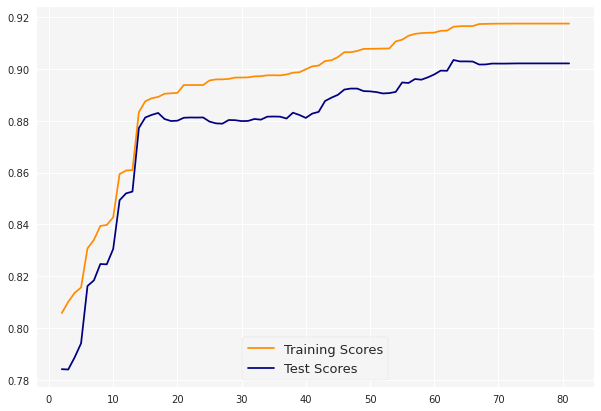

In [ ]:
N = len(train2.columns)-1 #原始成分數量
print(N)
scores_train = np.zeros(N)
scores_test = np.zeros(N)

for i in np.arange(N,2,-1): #從N遞減到2，
  model = make_pipeline(
      RobustScaler(),
      PCA(n_components=i),
      Ridge(alpha=1.5)
  )
  model.fit(X_train,y_train)
  scores_train[i-1] = model.score(X_train,y_train) #也可以換成其他想用的score
  scores_test[i-1] = model.score(X_test,y_test)

def start_plot(figsize=(10, 8), style = 'whitegrid'):
  fig = plt.figure(figsize=figsize)
  gs = fig.add_gridspec(1,1)
  plt.tight_layout()
  ax = fig.add_subplot(gs[0,0])
  return ax

xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(10,7))
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores')
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores')
ax.legend(loc='lower center',frameon=True,fontsize=13)

[0.009977386733290896, 0.00991412643787382, 0.009831857764236628, 0.009835205913049804, 0.009592953197305562, 0.009627155234600534, 0.00962753403727312, 0.009632195030851602, 0.00970570071691616, 0.009703976195145923, 0.009682385669522852, 0.009683565303978764, 0.009683599142893322, 0.009680793841992129, 0.009678468410710553]


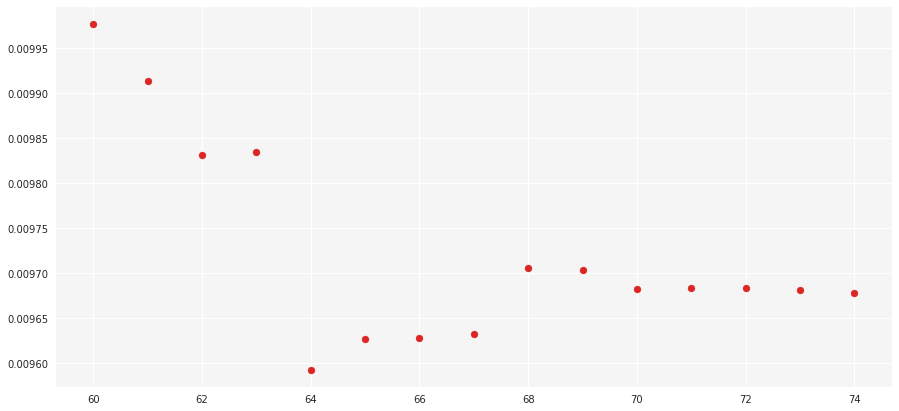

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

rmsle_score=[]
components=[i for i in range(60,75)]

for n in components:
    model = make_pipeline( RobustScaler(),PCA(n_components=n),Ridge(alpha=0.75) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7))
plt.scatter(components, rmsle_score)

[0.009691175693709357, 0.009690082241213155, 0.009688840909550276, 0.009685878052173363, 0.009683079360444704, 0.009682385669522852, 0.009683303867193595, 0.00968546949368346, 0.009688608246152587, 0.009692510481926363, 0.009697013857800507, 0.009701991226512309, 0.009707342023932706, 0.00971298602944219, 0.009718858773457855, 0.009724908109311182, 0.00973109162173006, 0.00973737464530417, 0.009743728733621696, 0.00976944428140246]


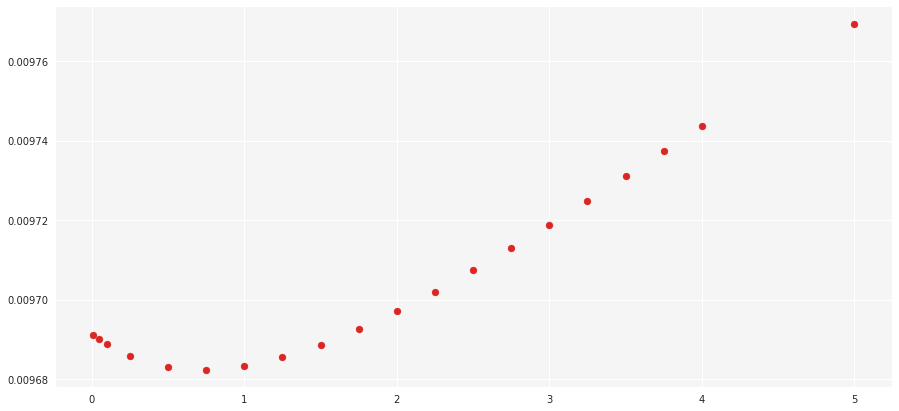

In [ ]:
rmsle_score=[]
alpha=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3,
    3.25, 3.5, 3.75, 4, 5]

for a in alpha:
    model = make_pipeline( RobustScaler(),PCA(n_components=70),Ridge(alpha=a) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7))
plt.scatter(alpha, rmsle_score)

###4.2.2 建模

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline( RobustScaler(),PCA(n_components=64),Ridge(alpha=0.01) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9044521342014575
Root Mean Squared Logarithmic Error: 0.009562895473011389
 
5fold-CV R-squared: [0.90828823 0.90937592 0.89481759 0.90133154 0.90377376]
5fold-CV R-squared Avg: 0.90351740843996
5fold-CV R-squared Std: 0.005246205556947555


In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline( RobustScaler(),PCA(n_components=70),Ridge(alpha=0.75) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9021121354856847
Root Mean Squared Logarithmic Error: 0.009682385669522852
 
5fold-CV R-squared: [0.90716869 0.90969606 0.89378931 0.90397543 0.90312211]
5fold-CV R-squared Avg: 0.90355031803901
5fold-CV R-squared Std: 0.005413021995449552


##4.3 預測Test資料集

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

model = make_pipeline( RobustScaler(),PCA(n_components=64),Ridge(alpha=0.01) )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)
y_pred

array([123027.67928268, 152441.16180255, 174393.21220191, ...,
       162973.53475307, 117425.23899262, 211829.97696287])

In [ ]:
submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,123027.679283
1,1462,152441.161803
2,1463,174393.212202
3,1464,186691.476014
4,1465,222986.920527


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/RobustScaler_PCA_Ridge_logy5.csv',index=False)

#5 測試5 (Score: 0.14271)

##5.1 特徵工程調整

In [ ]:
train = pd.read_csv(housepricetrain)
test = pd.read_csv(housepricetest)

###5.1.1 排除離群值

In [ ]:
out = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index
print(out)
print(train.shape)
#排除離群值
train.drop(out, inplace=True)
print(train.shape)

Int64Index([523, 1298], dtype='int64')
(1460, 81)
(1458, 81)


###5.1.2 定義特徵工程

In [ ]:
def cleanfeature(data):
  #補NoData
  #'MiscFeature','Fence','GarageCond','GarageFinish','GarageYrBlt','GarageType'
  #'BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','MasVnrType'
  #'PoolQC','FireplaceQu','BsmtExposure','Alley','FireplaceQu','GarageQual'
  for i in ['BsmtExposure','BsmtFinType2','FireplaceQu','GarageType','GarageFinish']:
    data[i].fillna('NoData', inplace=True)
  
  data['PoolQC'].replace({'Ex':1,'Fa':0,'Gd':0,np.nan:0},inplace=True)
  #補眾數
  #"MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional"
  #"Electrical", "KitchenQual", "SaleType", "Exterior1st", "Exterior2nd"

  #其他補缺失值
  data['MSZoning'].fillna('RL', inplace=True)
  data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)

  #缺失值補0
  #"BsmtUnfSF", "TotalBsmtSF", "BsmtFinSF2", "BsmtFinSF1"
  for i in ['BsmtQual','MasVnrArea']:
    data[i].fillna(0, inplace=True)

  
  #取log
  tmp = []
  for i in data.index:
    if data.loc[i,'LotFrontage']>0:
      tmp.append(np.log(data.loc[i,'LotFrontage']))
    else:
      tmp.append(0)
  data['LotFrontage_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'1stFlrSF']>0:
      tmp.append(np.log(data.loc[i,'1stFlrSF']))
    else:
      tmp.append(0)
  data['1stFlrSF_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'TotalBsmtSF']>0:
      tmp.append(np.log(data.loc[i,'TotalBsmtSF']))
    else:
      tmp.append(0)
  data['TotalBsmtSF_log'] = tmp
  
  #新欄位
  data['CarArea'] = data['GarageCars']/data['GarageArea']
  data['RoomArea'] = data['GrLivArea']/data['TotRmsAbvGrd']
  data['TotalHouse'] = data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
  data['TotalArea'] = data['TotalHouse']+data['GarageArea']
  data['PorchArea'] = data['OpenPorchSF']+data['EnclosedPorch']+data['3SsnPorch']+data['ScreenPorch']
  data['TotalPlace'] = data['TotalHouse']+data['GarageArea']+data['PorchArea']
  data['House_and_LotArea'] = data['TotalHouse']+data['LotArea']
  data['Bsmt'] = data['BsmtFinSF1']+data['BsmtFinSF2']+data['BsmtUnfSF']
  data['AllRooms'] = data['FullBath']+data['TotRmsAbvGrd']
  for i in ['CarArea','RoomArea','TotalHouse','TotalArea','PorchArea','TotalPlace','House_and_LotArea','Bsmt','AllRooms']:
    data[i].fillna(0, inplace=True)

  #數值轉類別
  data['OverallCond'].replace({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'},inplace=True)
  #train資料沒有150這類，看類別覺得150和75蠻接近的，先把它和75放同一類
  data['MSSubClass'].replace({20:'one',30:'two',40:'three',45:'four',50:'five',60:'six',70:'seven',75:'eight',80:'nine',85:'ten',90:'eleven',120:'twelve',150:'eight',160:'fourteen',180:'fifteen',190:'sixteen'},inplace=True)

  #挑出欄位
  #'PoolQC','FireplaceQu','BsmtExposure','Alley','FireplaceQu','GarageQual',\
  choose = ['BsmtExposure','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','PoolQC',\
            'MSZoning',\
            'BsmtQual','MasVnrArea',\
            'LotFrontage_log','1stFlrSF_log','TotalBsmtSF_log',\
            'CarArea','RoomArea',\
            'TotalHouse','TotalArea','PorchArea','TotalPlace','House_and_LotArea','Bsmt','AllRooms',\
            'OverallCond','MSSubClass',\
            'YearRemodAdd','FullBath','Neighborhood','OverallQual','HeatingQC','CentralAir']
        
  newdata = data.loc[:,choose]
  newdata = pd.get_dummies(newdata,drop_first=False)
  return newdata

In [ ]:
train2 = cleanfeature(train)
train2['SalePrice_log'] = np.log(train['SalePrice'])
print(train2.isnull().sum()[train2.isnull().sum()!=0])
train2.head(10)

Series([], dtype: int64)


,PoolQC,MasVnrArea,LotFrontage_log,1stFlrSF_log,TotalBsmtSF_log,CarArea,RoomArea,TotalHouse,TotalArea,PorchArea,TotalPlace,House_and_LotArea,Bsmt,AllRooms,YearRemodAdd,FullBath,OverallQual,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoData,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoData,BsmtFinType2_Rec,BsmtFinType2_Unf,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoData,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,...,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,SalePrice_log
0,0,196.0,4.174387,6.752270,6.752270,0.003650,213.750000,2566,3114,61,3175,11016,856,10,2003,2,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.247694
1,0,0.0,4.382027,7.140453,7.140453,0.004348,210.333333,2524,2984,0,2984,12124,1262,8,1976,2,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,12.109011
2,0,162.0,4.219508,6.824374,6.824374,0.003289,297.666667,2706,3314,42,3356,13956,920,8,2002,2,7,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.317167
3,0,0.0,4.094345,6.867974,6.628041,0.004673,245.285714,2473,3115,307,3422,12023,756,8,1970,1,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,11.849398
4,0,350.0,4.430817,7.043160,7.043160,0.003589,244.222222,3343,4179,84,4263,17603,1145,11,2000,2,8,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.429216
5,0,0.0,4.442651,6.679599,6.679599,0.004167,272.400000,2158,2638,350,2988,16273,796,6,1995,1,5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,11.870600
6,0,186.0,4.317488,7.434848,7.430114,0.003145,242.000000,3380,4016,57,4073,13464,1686,9,2005,2,8,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,12.634603
7,0,240.0,4.245596,7.009409,7.009409,0.004132,298.571429,3197,3681,432,4113,13579,1107,9,1973,2,7,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.206073
8,0,0.0,3.931826,6.929517,6.858565,0.004274,221.750000,2726,3194,205,3399,8846,952,10,1950,2,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,11.774520
9,0,0.0,3.912023,6.981935,6.898715,0.004878,215.400000,2068,2273,4,2277,9488,991,6,1950,1,5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,11.678440


In [ ]:
X_realtest = cleanfeature(test)
print(X_realtest.isnull().sum()[X_realtest.isnull().sum()!=0])
X_realtest.head()

Series([], dtype: int64)


,PoolQC,MasVnrArea,LotFrontage_log,1stFlrSF_log,TotalBsmtSF_log,CarArea,RoomArea,TotalHouse,TotalArea,PorchArea,TotalPlace,House_and_LotArea,Bsmt,AllRooms,YearRemodAdd,FullBath,OverallQual,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoData,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoData,BsmtFinType2_Rec,BsmtFinType2_Unf,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoData,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,...,MSSubClass_one,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y
0,0,0.0,4.382027,6.797940,6.782192,0.001370,179.200000,1778.0,2508.0,120,2628.0,13400.0,882.0,6,1961,1,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,108.0,4.394449,7.192182,7.192182,0.003205,221.500000,2658.0,2970.0,36,3006.0,16925.0,1329.0,7,1958,1,6,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,0.0,4.304065,6.833032,6.833032,0.004149,271.500000,2557.0,3039.0,34,3073.0,16387.0,928.0,8,1998,2,5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0,20.0,4.356709,6.830874,6.830874,0.004255,229.142857,2530.0,3000.0,36,3036.0,12508.0,926.0,9,1998,2,6,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0.0,3.761200,7.154615,7.154615,0.003953,256.000000,2560.0,3066.0,226,3292.0,7565.0,1280.0,7,1992,2,8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [ ]:
traincol = list(train2.drop('SalePrice_log', axis = 1).columns)
testcol = list(X_realtest.columns)
col_diff1 = list(set(testcol).difference(set(traincol)))
print(col_diff1)
col_diff2 = list(set(traincol).difference(set(testcol)))
print(col_diff2)

[]
[]


##5.2 Train資料嘗試建模

###5.2.1 調整模型

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

112


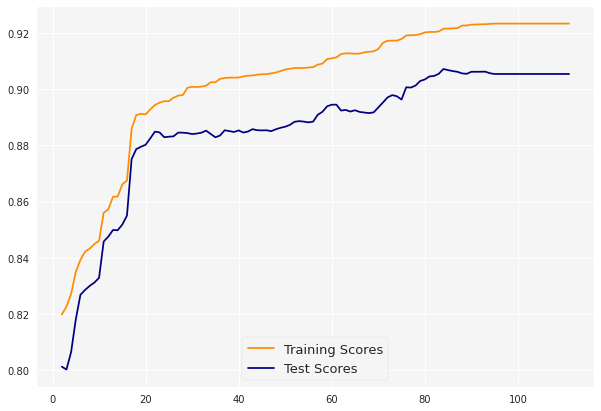

In [ ]:
N = len(train2.columns)-1 #原始成分數量
print(N)
scores_train = np.zeros(N)
scores_test = np.zeros(N)

for i in np.arange(N,2,-1): #從N遞減到2，
  model = make_pipeline(
      RobustScaler(),
      PCA(n_components=i),
      Ridge(alpha=1.5)
  )
  model.fit(X_train,y_train)
  scores_train[i-1] = model.score(X_train,y_train) #也可以換成其他想用的score
  scores_test[i-1] = model.score(X_test,y_test)

def start_plot(figsize=(10, 8), style = 'whitegrid'):
  fig = plt.figure(figsize=figsize)
  gs = fig.add_gridspec(1,1)
  plt.tight_layout()
  ax = fig.add_subplot(gs[0,0])
  return ax

xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(10,7))
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores')
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores')
ax.legend(loc='lower center',frameon=True,fontsize=13)

[0.010001873159177378, 0.010058464322997566, 0.00980693862201959, 0.009812900444480598, 0.009775511908502885, 0.009678694638255566, 0.009649175442696268, 0.009575244702206219, 0.009563305578358857, 0.009510279460799785, 0.009403118494250854, 0.009436085723811147, 0.009468014877868384, 0.009488394414797591, 0.009559415348605563, 0.009576598850410562, 0.009521975797332997, 0.00952301482592825, 0.009523633542829814, 0.009521534520602053]


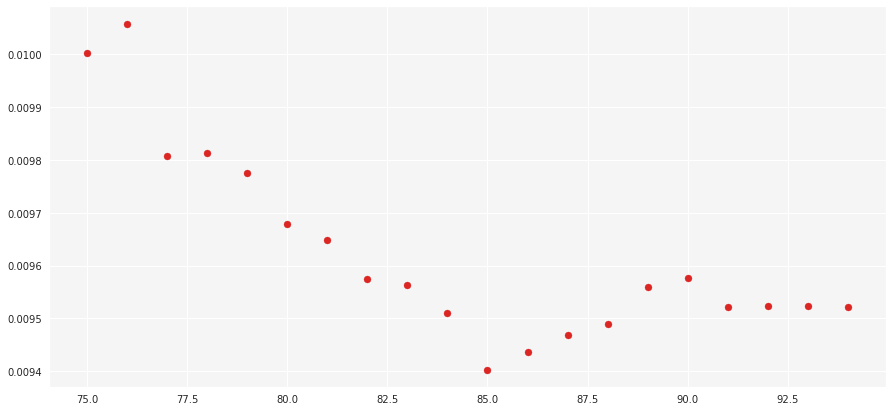

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

rmsle_score=[]
components=[i for i in range(75,95)]

for n in components:
    model = make_pipeline( RobustScaler(),PCA(n_components=n),Ridge(alpha=0.01) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7))
plt.scatter(components, rmsle_score)

[0.00940314021674858, 0.009404725572975791, 0.009406772623717873, 0.009412834507122242, 0.009423113848762904, 0.009433404985698527, 0.009443636886575993, 0.009453830603446182, 0.009463937374327018, 0.009473927997271921, 0.009483779175432942, 0.00949349099632892, 0.009503072619353539, 0.009512490448877925, 0.009521749912628497, 0.009530851361460311, 0.009539798538874622, 0.009548587774338388, 0.009557224649300693, 0.009590243623029668]


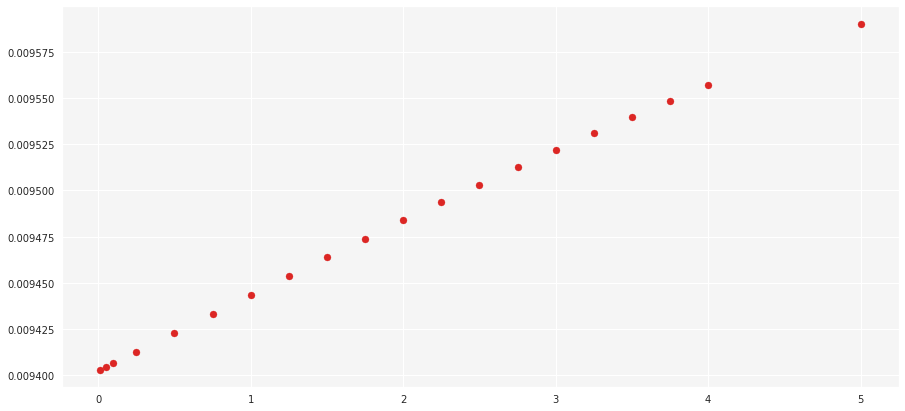

In [ ]:
rmsle_score=[]
alpha=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3,
    3.25, 3.5, 3.75, 4, 5]

for a in alpha:
    model = make_pipeline( RobustScaler(),PCA(n_components=85),Ridge(alpha=a) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7))
plt.scatter(alpha, rmsle_score)

###5.2.2 建模

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline( RobustScaler(),PCA(n_components=85),Ridge(alpha=0.01) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9081095728247884
Root Mean Squared Logarithmic Error: 0.009403120533178851
 
5fold-CV R-squared: [0.90387753 0.90860475 0.89733696 0.90936962 0.90394966]
5fold-CV R-squared Avg: 0.9046277051103007
5fold-CV R-squared Std: 0.00430069906256886


##5.3 預測Test資料集

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

model = make_pipeline( RobustScaler(),PCA(n_components=64),Ridge(alpha=0.01) )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)
y_pred

array([119230.32087308, 149252.69995114, 170339.39699966, ...,
       164253.40469058, 109326.72127369, 232454.90291025])

In [ ]:
submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,119230.320873
1,1462,149252.699951
2,1463,170339.397000
3,1464,181156.960120
4,1465,195255.160994


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/RobustScaler_PCA_Ridge_logy6.csv',index=False)

#6 測試6 (Score: 0.13896)

##6.1 特徵工程調整

In [ ]:
train = pd.read_csv(housepricetrain)
test = pd.read_csv(housepricetest)

###6.1.1 排除離群值

In [ ]:
out = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index
train.drop(out, inplace=True)

###6.1.2 定義特徵工程

In [ ]:
def cleanfeature(data):
  #補NoData
  #'MiscFeature','Fence','GarageCond','GarageYrBlt'
  #'BsmtCond','BsmtQual','BsmtFinType1','MasVnrType'
  #'Alley','FireplaceQu','GarageQual'
  for i in ['BsmtExposure','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','BsmtQual']:
    data[i].fillna('NoData', inplace=True)
  
  data['PoolQC'].replace({'Ex':1,'Fa':0,'Gd':0,np.nan:0},inplace=True)
  #補眾數
  #'BsmtFullBath','BsmtHalfBath','Utilities'
  #'Electrical','SaleType','Exterior1st','Exterior2nd'
  for i in ['MSZoning','Functional','KitchenQual']:
    data[i].fillna(data[i].mode(), inplace=True)
  
  #補平均值
  data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)

  #缺失值補0
  for i in ['MasVnrArea','GarageCars','GarageArea','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']:
    data[i].fillna(0, inplace=True)

  
  #取log
  tmp = []
  for i in data.index:
    if data.loc[i,'LotFrontage']>0:
      tmp.append(np.log(data.loc[i,'LotFrontage']))
    else:
      tmp.append(0)
  data['LotFrontage_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'1stFlrSF']>0:
      tmp.append(np.log(data.loc[i,'1stFlrSF']))
    else:
      tmp.append(0)
  data['1stFlrSF_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'TotalBsmtSF']>0:
      tmp.append(np.log(data.loc[i,'TotalBsmtSF']))
    else:
      tmp.append(0)
  data['TotalBsmtSF_log'] = tmp
  
  #新欄位
  data['CarArea'] = data['GarageCars']/data['GarageArea']
  data['RoomArea'] = data['GrLivArea']/data['TotRmsAbvGrd']
  data['TotalHouse'] = data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
  data['TotalArea'] = data['TotalHouse']+data['GarageArea']
  data['PorchArea'] = data['OpenPorchSF']+data['EnclosedPorch']+data['3SsnPorch']+data['ScreenPorch']
  data['TotalPlace'] = data['TotalHouse']+data['GarageArea']+data['PorchArea']
  data['House_and_LotArea'] = data['TotalHouse']+data['LotArea']
  data['Bsmt'] = data['BsmtFinSF1']+data['BsmtFinSF2']+data['BsmtUnfSF']
  data['AllRooms'] = data['FullBath']+data['TotRmsAbvGrd']
  for i in ['CarArea','RoomArea','TotalHouse','TotalArea','PorchArea','TotalPlace','House_and_LotArea','Bsmt','AllRooms']:
    data[i].fillna(0, inplace=True)

  #數值轉類別
  data['OverallCond'].replace({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'},inplace=True)
  #train資料沒有150這類，看類別覺得150和75蠻接近的，先把它和75放同一類
  data['MSSubClass'].replace({20:'one',30:'two',40:'three',45:'four',50:'five',60:'six',70:'seven',75:'eight',80:'nine',85:'ten',90:'eleven',120:'twelve',150:'eight',160:'fourteen',180:'fifteen',190:'sixteen'},inplace=True)

  #挑出欄位
  choose = ['BsmtExposure','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','PoolQC','BsmtQual',\
            'MSZoning','Functional',\
            'MasVnrArea',\
            'LotFrontage_log','1stFlrSF_log','TotalBsmtSF_log',\
            'CarArea','RoomArea',\
            'TotalHouse','TotalArea','PorchArea','TotalPlace','House_and_LotArea','Bsmt','AllRooms',\
            'OverallCond','MSSubClass',\
            'YearRemodAdd','FullBath','Neighborhood','OverallQual','HeatingQC','CentralAir','2ndFlrSF',\
            'YearBuilt']
        
  newdata = data.loc[:,choose]
  newdata = pd.get_dummies(newdata,drop_first=False)
  return newdata

In [ ]:
train2 = cleanfeature(train)
train2['SalePrice_log'] = np.log(train['SalePrice'])
print(train2.isnull().sum()[train2.isnull().sum()!=0])
train2.head()

Series([], dtype: int64)


,PoolQC,MasVnrArea,LotFrontage_log,1stFlrSF_log,TotalBsmtSF_log,CarArea,RoomArea,TotalHouse,TotalArea,PorchArea,TotalPlace,House_and_LotArea,Bsmt,AllRooms,YearRemodAdd,FullBath,OverallQual,2ndFlrSF,YearBuilt,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoData,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoData,BsmtFinType2_Rec,BsmtFinType2_Unf,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoData,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,...,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,SalePrice_log
0,0,196.0,4.174387,6.752270,6.752270,0.003650,213.750000,2566,3114,61,3175,11016,856,10,2003,2,7,854,2003,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.247694
1,0,0.0,4.382027,7.140453,7.140453,0.004348,210.333333,2524,2984,0,2984,12124,1262,8,1976,2,6,0,1976,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,12.109011
2,0,162.0,4.219508,6.824374,6.824374,0.003289,297.666667,2706,3314,42,3356,13956,920,8,2002,2,7,866,2001,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.317167
3,0,0.0,4.094345,6.867974,6.628041,0.004673,245.285714,2473,3115,307,3422,12023,756,8,1970,1,7,756,1915,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,11.849398
4,0,350.0,4.430817,7.043160,7.043160,0.003589,244.222222,3343,4179,84,4263,17603,1145,11,2000,2,8,1053,2000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,12.429216


In [ ]:
X_realtest = cleanfeature(test)
print(X_realtest.isnull().sum()[X_realtest.isnull().sum()!=0])
X_realtest.head()

Series([], dtype: int64)


,PoolQC,MasVnrArea,LotFrontage_log,1stFlrSF_log,TotalBsmtSF_log,CarArea,RoomArea,TotalHouse,TotalArea,PorchArea,TotalPlace,House_and_LotArea,Bsmt,AllRooms,YearRemodAdd,FullBath,OverallQual,2ndFlrSF,YearBuilt,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoData,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoData,BsmtFinType2_Rec,BsmtFinType2_Unf,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoData,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,...,MSSubClass_one,MSSubClass_seven,MSSubClass_six,MSSubClass_sixteen,MSSubClass_ten,MSSubClass_three,MSSubClass_twelve,MSSubClass_two,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y
0,0,0.0,4.382027,6.797940,6.782192,0.001370,179.200000,1778.0,2508.0,120,2628.0,13400.0,882.0,6,1961,1,5,0,1961,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,108.0,4.394449,7.192182,7.192182,0.003205,221.500000,2658.0,2970.0,36,3006.0,16925.0,1329.0,7,1958,1,6,0,1958,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,0.0,4.304065,6.833032,6.833032,0.004149,271.500000,2557.0,3039.0,34,3073.0,16387.0,928.0,8,1998,2,5,701,1997,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0,20.0,4.356709,6.830874,6.830874,0.004255,229.142857,2530.0,3000.0,36,3036.0,12508.0,926.0,9,1998,2,6,678,1998,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0.0,3.761200,7.154615,7.154615,0.003953,256.000000,2560.0,3066.0,226,3292.0,7565.0,1280.0,7,1992,2,8,0,1992,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


##6.2 Train資料嘗試建模

###6.2.1 調整模型

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

121


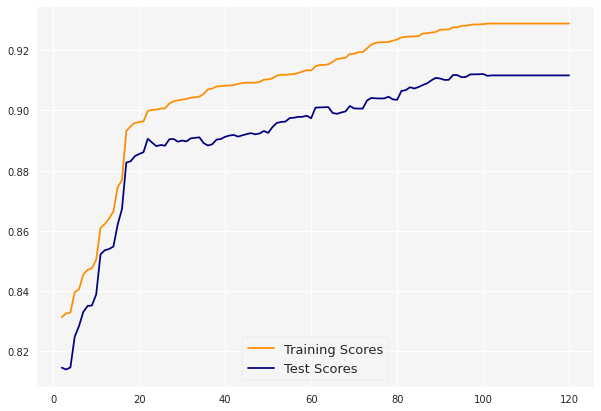

In [ ]:
N = len(train2.columns)-1 #原始成分數量
print(N)
scores_train = np.zeros(N)
scores_test = np.zeros(N)

for i in np.arange(N,2,-1): #從N遞減到2，
  model = make_pipeline(
      RobustScaler(),
      PCA(n_components=i),
      Ridge(alpha=1.5)
  )
  model.fit(X_train,y_train)
  scores_train[i-1] = model.score(X_train,y_train) #也可以換成其他想用的score
  scores_test[i-1] = model.score(X_test,y_test)

def start_plot(figsize=(10, 8), style = 'whitegrid'):
  fig = plt.figure(figsize=figsize)
  gs = fig.add_gridspec(1,1)
  plt.tight_layout()
  ax = fig.add_subplot(gs[0,0])
  return ax

xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(10,7))
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores')
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores')
ax.legend(loc='lower center',frameon=True,fontsize=13)

[0.00926767281695354, 0.009280198210250624, 0.009309125320955337, 0.009308271614272317, 0.009214711590016054, 0.00921677687803294, 0.009261258927974247, 0.009254828460773818, 0.009197153598075542, 0.009198416436755423, 0.009196644925656356, 0.00919026119537243, 0.009238561073447985, 0.009226669448616347, 0.009226669448616347]


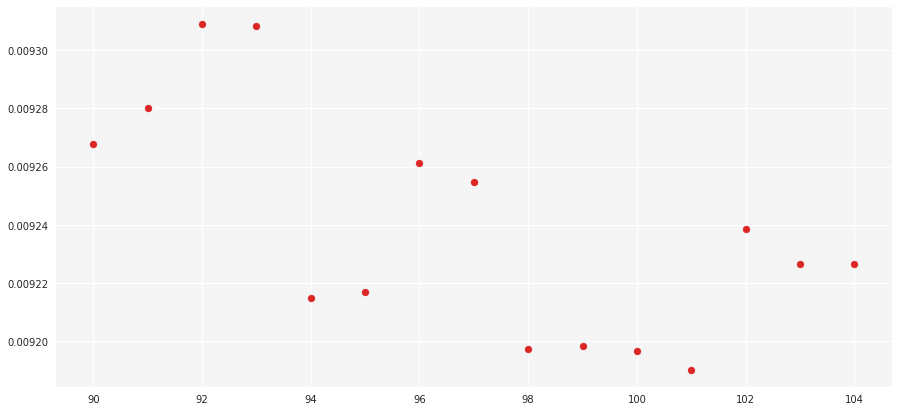

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

rmsle_score=[]
components=[i for i in range(90,105)]

for n in components:
  model = make_pipeline( RobustScaler(),PCA(n_components=n),Ridge(alpha=0.75) )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7))
plt.scatter(components, rmsle_score)

[0.00920305739363348, 0.009201055516038645, 0.009198888697026559, 0.009194187200370208, 0.009190552987531448, 0.00919026119537243, 0.009192100187277336, 0.009195381748056227, 0.009199678338840462, 0.009204706978246916, 0.009210271483834328, 0.00921623103892012, 0.009222481838471354, 0.009228945753316994, 0.00923556300403883, 0.009242287247168407, 0.009249082176529979, 0.009255919111299053, 0.009262775246653244, 0.009290077293307861]


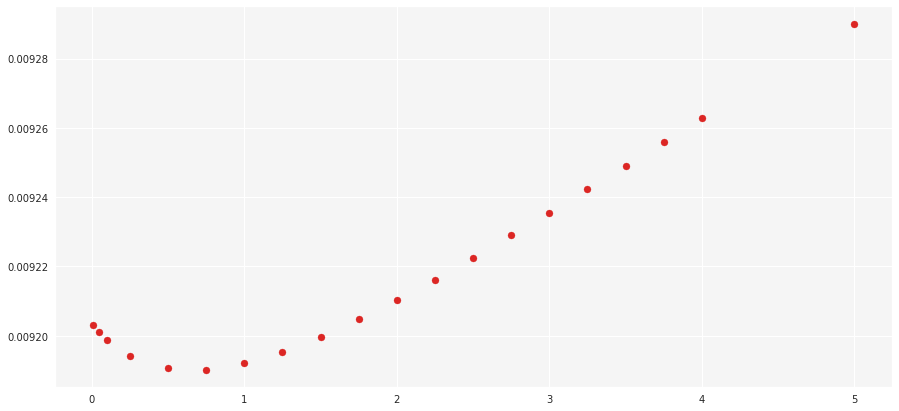

In [ ]:
rmsle_score=[]
alpha=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3,
    3.25, 3.5, 3.75, 4, 5]

for a in alpha:
    model = make_pipeline( RobustScaler(),PCA(n_components=101),Ridge(alpha=a) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7))
plt.scatter(alpha, rmsle_score)

###6.2.2 建模

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline( RobustScaler(),PCA(n_components=101),Ridge(alpha=0.75) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9121635773343981
Root Mean Squared Logarithmic Error: 0.00919026119537243
 
5fold-CV R-squared: [0.90869481 0.91694875 0.9030111  0.91874728 0.91004798]
5fold-CV R-squared Avg: 0.9114899849153181
5fold-CV R-squared Std: 0.005731499723977509


##6.3 預測Test資料集

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

model = make_pipeline( RobustScaler(),PCA(n_components=64),Ridge(alpha=0.01) )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)

submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,118525.762545
1,1462,149834.388174
2,1463,172650.137114
3,1464,187828.097684
4,1465,192725.032681


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/RobustScaler_PCA_Ridge_logy7.csv',index=False)

#7 測試7 (Score: 0.13409)
Top 36%

In [ ]:
train = pd.read_csv(housepricetrain)
test = pd.read_csv(housepricetest)

##7.1 特徵工程調整

In [ ]:
out = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index
train.drop(out, inplace=True)

In [ ]:
def cleanfeature(data):
  #補NoData
  #'MiscFeature','Fence','GarageCond','GarageYrBlt'
  #'BsmtQual','MasVnrType'
  #'Alley','FireplaceQu','GarageQual'
  for i in ['BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','BsmtQual','BsmtCond','MasVnrType']:
    data[i].fillna('NoData', inplace=True)
  
  data['PoolQC'].replace({'Ex':1,'Fa':0,'Gd':0,np.nan:0},inplace=True)
  #補眾數
  #'BsmtFullBath','BsmtHalfBath','Utilities'
  #'Electrical'
  for i in ['MSZoning','Functional','KitchenQual','SaleType']:
    data[i].fillna(data[i].mode(), inplace=True)
  
  #補平均值
  data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)

  #缺失值補0
  for i in ['MasVnrArea','GarageCars','GarageArea','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','HalfBath']:
    data[i].fillna(0, inplace=True)

  
  #取log
  tmp = []
  for i in data.index:
    if data.loc[i,'LotFrontage']>0:
      tmp.append(np.log(data.loc[i,'LotFrontage']))
    else:
      tmp.append(0)
  data['LotFrontage_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'1stFlrSF']>0:
      tmp.append(np.log(data.loc[i,'1stFlrSF']))
    else:
      tmp.append(0)
  data['1stFlrSF_log'] = tmp

  tmp = []
  for i in data.index:
    if data.loc[i,'TotalBsmtSF']>0:
      tmp.append(np.log(data.loc[i,'TotalBsmtSF']))
    else:
      tmp.append(0)
  data['TotalBsmtSF_log'] = tmp
  
  #新欄位
  data['CarArea'] = data['GarageCars']/data['GarageArea']
  data['RoomArea'] = data['GrLivArea']/data['TotRmsAbvGrd']
  data['TotalHouse'] = data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
  data['TotalArea'] = data['TotalHouse']+data['GarageArea']
  data['PorchArea'] = data['OpenPorchSF']+data['EnclosedPorch']+data['3SsnPorch']+data['ScreenPorch']
  data['TotalPlace'] = data['TotalHouse']+data['GarageArea']+data['PorchArea']
  data['House_and_LotArea'] = data['TotalHouse']+data['LotArea']
  data['Bsmt'] = data['BsmtFinSF1']+data['BsmtFinSF2']+data['BsmtUnfSF']
  data['AllRooms'] = data['FullBath']+(0.5*data['HalfBath'])+data['TotRmsAbvGrd']
  for i in ['CarArea','RoomArea','TotalHouse','TotalArea','PorchArea','TotalPlace','House_and_LotArea','Bsmt','AllRooms']:
    data[i].fillna(0, inplace=True)

  #數值轉類別
  data['OverallCond'].replace({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'},inplace=True)
  #train資料沒有150這類，看類別覺得150和75蠻接近的，先把它和75放同一類
  data['MSSubClass'].replace({20:'one',30:'two',40:'three',45:'four',50:'five',60:'six',70:'seven',75:'eight',80:'nine',85:'ten',90:'eleven',120:'twelve',150:'eight',160:'fourteen',180:'fifteen',190:'sixteen'},inplace=True)

  #挑出欄位
  choose = ['BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','PoolQC','BsmtQual','BsmtCond','MasVnrType',\
            'MSZoning','Functional','KitchenQual','SaleType',\
            'MasVnrArea',\
            'LotFrontage_log','1stFlrSF_log','TotalBsmtSF_log',\
            'CarArea','RoomArea',\
            'TotalHouse','TotalArea','PorchArea','TotalPlace','House_and_LotArea','Bsmt','AllRooms',\
            'OverallCond','MSSubClass',\
            'YearRemodAdd','FullBath','Neighborhood','OverallQual','HeatingQC','CentralAir','2ndFlrSF','YearBuilt',\
            'LandSlope','Fireplaces','PavedDrive','LandContour','RoofStyle','Foundation','SaleCondition']
        
  newdata = data.loc[:,choose]
  newdata = pd.get_dummies(newdata,drop_first=False)
  return newdata

In [ ]:
train2 = cleanfeature(train)
train2['SalePrice_log'] = np.log(train['SalePrice'])
print(train2.isnull().sum()[train2.isnull().sum()!=0])
train2.head()

Series([], dtype: int64)


,PoolQC,MasVnrArea,LotFrontage_log,1stFlrSF_log,TotalBsmtSF_log,CarArea,RoomArea,TotalHouse,TotalArea,PorchArea,TotalPlace,House_and_LotArea,Bsmt,AllRooms,YearRemodAdd,FullBath,OverallQual,2ndFlrSF,YearBuilt,Fireplaces,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoData,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoData,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoData,BsmtFinType2_Rec,BsmtFinType2_Unf,FireplaceQu_Ex,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice_log
0,0,196.0,4.174387,6.752270,6.752270,0.003650,213.750000,2566,3114,61,3175,11016,856,10.5,2003,2,7,854,2003,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,12.247694
1,0,0.0,4.382027,7.140453,7.140453,0.004348,210.333333,2524,2984,0,2984,12124,1262,8.0,1976,2,6,0,1976,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,12.109011
2,0,162.0,4.219508,6.824374,6.824374,0.003289,297.666667,2706,3314,42,3356,13956,920,8.5,2002,2,7,866,2001,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,12.317167
3,0,0.0,4.094345,6.867974,6.628041,0.004673,245.285714,2473,3115,307,3422,12023,756,8.0,1970,1,7,756,1915,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,11.849398
4,0,350.0,4.430817,7.043160,7.043160,0.003589,244.222222,3343,4179,84,4263,17603,1145,11.5,2000,2,8,1053,2000,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,12.429216


In [ ]:
X_realtest = cleanfeature(test)
print(X_realtest.isnull().sum()[X_realtest.isnull().sum()!=0])
X_realtest.head()

Series([], dtype: int64)


,PoolQC,MasVnrArea,LotFrontage_log,1stFlrSF_log,TotalBsmtSF_log,CarArea,RoomArea,TotalHouse,TotalArea,PorchArea,TotalPlace,House_and_LotArea,Bsmt,AllRooms,YearRemodAdd,FullBath,OverallQual,2ndFlrSF,YearBuilt,Fireplaces,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoData,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoData,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoData,BsmtFinType2_Rec,BsmtFinType2_Unf,FireplaceQu_Ex,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0.0,4.382027,6.797940,6.782192,0.001370,179.200000,1778.0,2508.0,120,2628.0,13400.0,882.0,6.0,1961,1,5,0,1961,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,108.0,4.394449,7.192182,7.192182,0.003205,221.500000,2658.0,2970.0,36,3006.0,16925.0,1329.0,7.5,1958,1,6,0,1958,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0.0,4.304065,6.833032,6.833032,0.004149,271.500000,2557.0,3039.0,34,3073.0,16387.0,928.0,8.5,1998,2,5,701,1997,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,20.0,4.356709,6.830874,6.830874,0.004255,229.142857,2530.0,3000.0,36,3036.0,12508.0,926.0,9.5,1998,2,6,678,1998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0.0,3.761200,7.154615,7.154615,0.003953,256.000000,2560.0,3066.0,226,3292.0,7565.0,1280.0,7.0,1992,2,8,0,1992,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
traincol = list(train2.drop('SalePrice_log', axis = 1).columns)
testcol = list(X_realtest.columns)
col_diff1 = list(set(testcol).difference(set(traincol)))
print(col_diff1)
col_diff2 = list(set(traincol).difference(set(testcol)))
print(col_diff2)

[]
[]


##7.2 Train資料嘗試建模

###7.2.1 調整模型

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

180


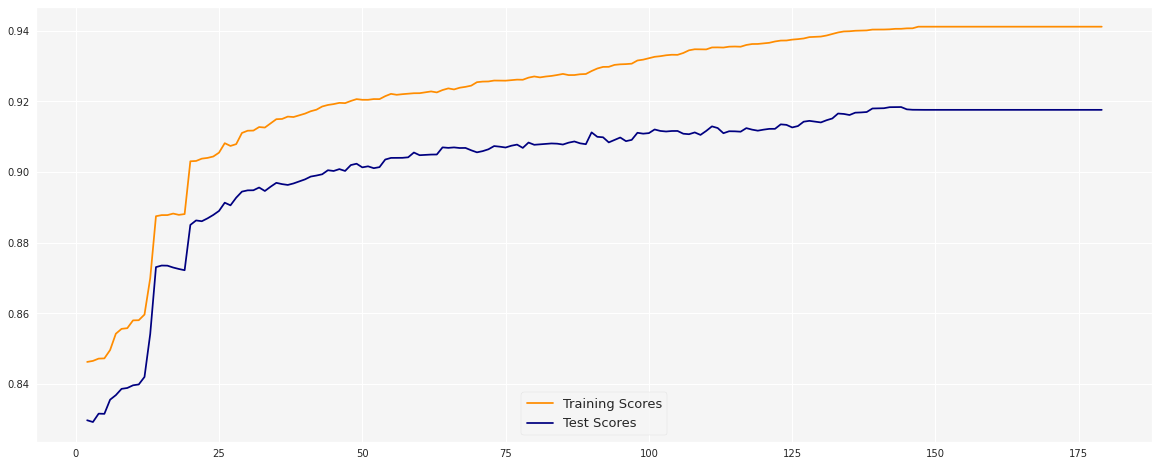

In [ ]:
N = len(train2.columns)-1 #原始成分數量
print(N)
scores_train = np.zeros(N)
scores_test = np.zeros(N)

for i in np.arange(N,2,-1): #從N遞減到2，
    model = make_pipeline(
      RobustScaler(),
      PCA(n_components=i),
      Ridge(alpha=1.5) )
    model.fit(X_train,y_train)
    scores_train[i-1] = model.score(X_train,y_train) #也可以換成其他想用的score
    scores_test[i-1] = model.score(X_test,y_test)

def start_plot(figsize=(10, 8), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    ax = fig.add_subplot(gs[0,0])
    return ax

xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(20,8));
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores');
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores');
ax.legend(loc='lower center',frameon=True,fontsize=13);

[0.009130579919469419, 0.009148472028710442, 0.009113279535314057, 0.009083163361737964, 0.008995238342604328, 0.009005761615153093, 0.009026152665235317, 0.008980397777882636, 0.008976409301028221, 0.008970978151153632, 0.008899955631698027, 0.00889657008710232, 0.008895180499007742, 0.008874889672674092, 0.008875427206292011, 0.008872607680071367, 0.008924088152482343, 0.008935471898444515, 0.008964148082801824, 0.008964148082801826]


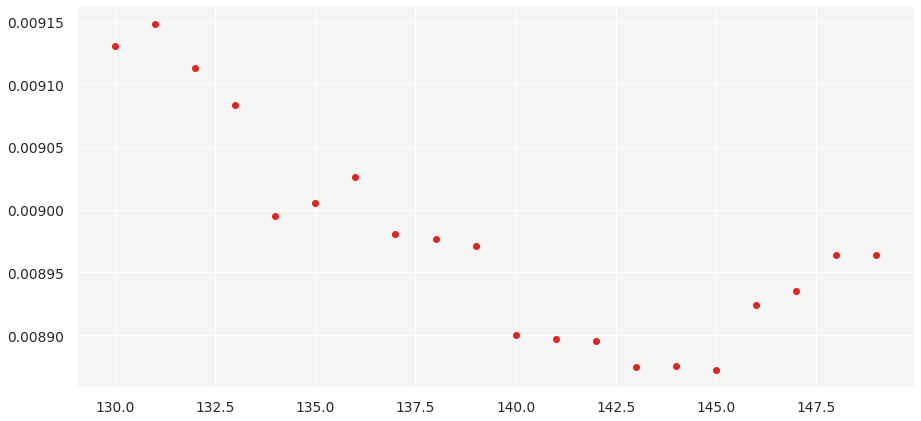

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

rmsle_score=[]
components=[i for i in range(130,150)]

for n in components:
    model = make_pipeline( RobustScaler(),PCA(n_components=n),Ridge(alpha=0.75) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7));
plt.scatter(components, rmsle_score);

[0.008895619928713246, 0.008892570964622358, 0.008889246844985755, 0.008881810001751946, 0.008875076460037233, 0.008872607680071367, 0.008872721846241242, 0.008874511313854047, 0.008877434434247, 0.008881145144655751, 0.008885411458773772, 0.0088900723189525, 0.008895012931382652, 0.00890014980828785, 0.008905421267741966, 0.008910781173735314, 0.008916194686594332, 0.008921635306437874, 0.008927082773507755, 0.008948679755936063]


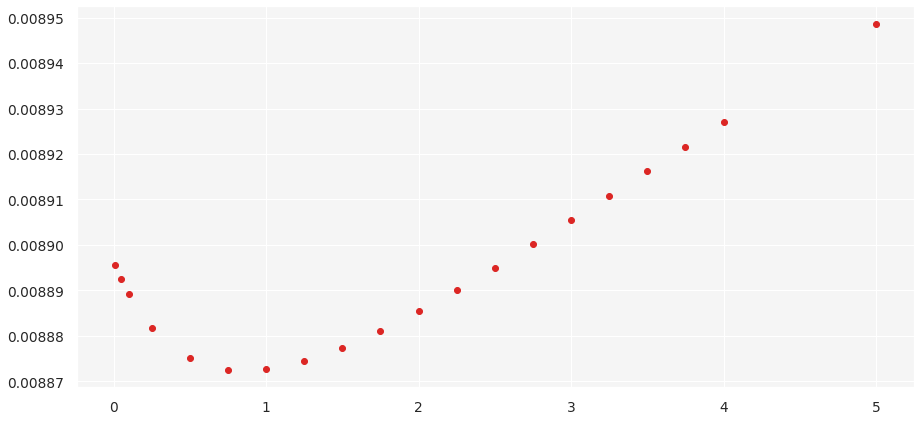

In [ ]:
rmsle_score=[]
alpha=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3,
    3.25, 3.5, 3.75, 4, 5]

for a in alpha:
    model = make_pipeline( RobustScaler(),PCA(n_components=145),Ridge(alpha=a) )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))


print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7));
plt.scatter(alpha, rmsle_score);

###7.2.2 建模

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline( RobustScaler(),PCA(n_components=145),Ridge(alpha=0.75) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9183935038636898
Root Mean Squared Logarithmic Error: 0.008872607680071367
 
5fold-CV R-squared: [0.91811468 0.92452649 0.9039674  0.91980978 0.90778994]
5fold-CV R-squared Avg: 0.9148416582463256
5fold-CV R-squared Std: 0.007709306128002867


##7.3 預測Test資料集

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

model = make_pipeline( RobustScaler(),PCA(n_components=145),Ridge(alpha=0.75) )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)

submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,127252.248879
1,1462,154561.754855
2,1463,185016.758529
3,1464,197439.486222
4,1465,210380.295540


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/RobustScaler_PCA_Ridge_logy10.csv',index=False)

#8 測試8，把測試7的PCA換成RFE (Score: 0.14104)

##8.2 Train資料嘗試建模

###8.2.1 調整模型

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = RobustScaler()
scaler.fit_transform(X_train)
scaler.transform(X_train)

[0.01063307747236604, 0.010521666192249953, 0.010428157633674925, 0.010299298977830447, 0.010083960234549888, 0.010068046083137373, 0.010022994686309027, 0.010047185880843409, 0.010047316540173356, 0.010030475140298903, 0.010080935275965623, 0.01004739846180575, 0.010124163054103087, 0.010265038207371853, 0.010063493534371944, 0.010058987520218835, 0.010082408215155906, 0.01006094980911366, 0.010113169097094832, 0.010106898304429165]


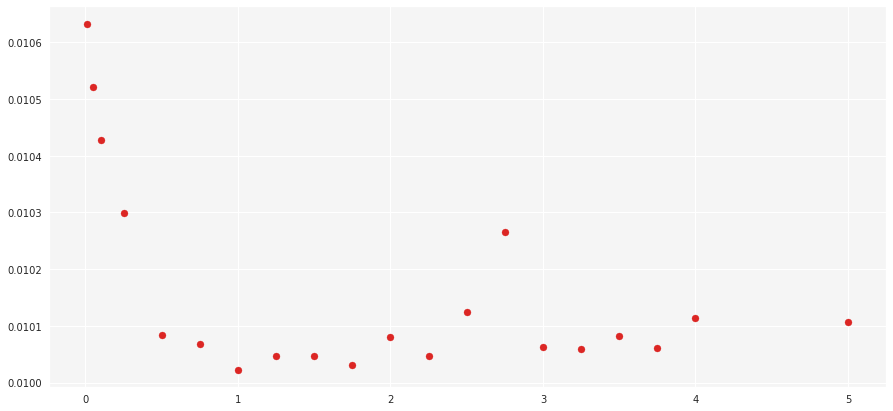

In [ ]:
rmsle_score=[]
alpha=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3,
    3.25, 3.5, 3.75, 4, 5]

for a in alpha:
    selector = RFE(Ridge(alpha=a))
    selector.fit(X_train, y_train)
    y_pred = selector.predict(X_test)
    rmsle_score.append(rmsle(y_test, y_pred))

print(rmsle_score)
fig,ax = plt.subplots(figsize=(15,7));
plt.scatter(alpha, rmsle_score);

###8.2.2 建模

In [ ]:
from sklearn.feature_selection import RFE

X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = RobustScaler()
scaler.fit_transform(X_train)
scaler.transform(X_train)

selector = RFE(Ridge(alpha=1))
selector.fit(X_train, y_train)
y_pred = selector.predict(X_test)

print('選了%d個特徵' % selector.support_.sum())
#print(selector.support_)
#print(selector.ranking_)
print(' ')
print('R-squared:',selector.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(selector, X, y, cv=5) #5fold-CV，score是回傳R-square
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

選了90個特徵
 
R-squared: 0.8944087758626795
Root Mean Squared Logarithmic Error: 0.010022994686309027
 
5fold-CV R-squared: [0.90398043 0.90212124 0.8797255  0.88913532 0.88275861]
5fold-CV R-squared Avg: 0.891544220240134
5fold-CV R-squared Std: 0.00989145547684167


好像...比測試7差耶

```
測試7
R-squared: 0.9183935038636898
Root Mean Squared Logarithmic Error: 0.008872607680071367
 
5fold-CV R-squared: [0.91811468 0.92452649 0.9039674  0.91980978 0.90778994]
5fold-CV R-squared Avg: 0.9148416582463256
5fold-CV R-squared Std: 0.007709306128002867
```



##8.3 預測Test資料集

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

scaler = RobustScaler()
scaler.fit_transform(X)
scaler.transform(X)

selector = RFE(Ridge(alpha=1))
selector.fit(X, y)
y_pred = selector.predict(X_realtest)
y_pred = np.exp(y_pred)

submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,126530.994040
1,1462,156671.595564
2,1463,178302.564128
3,1464,193735.237557
4,1465,219493.240029


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/RobustScaler_RFE_Ridge_logy.csv',index=False)

# 10 測試10

In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler',RobustScaler() ),
            ('XGB',XGBRegressor(objective='reg:squarederror') ) ]) 

param_XGB = {
    'XGB__n_estimators':[500,750,1000,1250,1500,2000], #n_estimators=100
    'XGB__max_depth':[3,4,5,6], #default=3，越大越容易overfitting，查了一下通常設3~10
    'XGB__min_child_weight':[3,4,5,6], #default=1，越小越容易overfitting
    'XGB__learning_rate':[0.01,0.02,0.03,0.04,0.05], #default=0.1
    }
XGB_gsearch = GridSearchCV(estimator=pipeline, param_grid=param_XGB, scoring='r2', cv=5)
XGB_gsearch.fit(X_train, y_train)

print('best scores:', XGB_gsearch.best_score_)
print('best params:', XGB_gsearch.best_params_)

best scores: 0.9031368625961053
best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__min_child_weight': 6, 'XGB__n_estimators': 2000}
CPU times: user 2h 46min 25s, sys: 27 s, total: 2h 46min 52s
Wall time: 2h 47min 15s


## 10.2 Train資料嘗試建模

### 10.2.1 調整模型

180


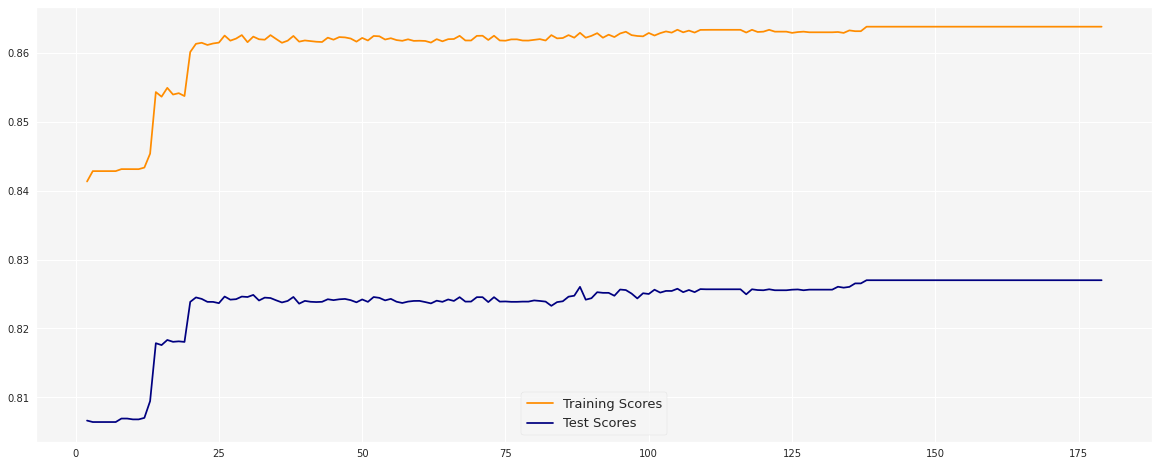

In [ ]:
%%time
N = len(train2.columns)-1 #原始成分數量
print(N)
scores_train = np.zeros(N)
scores_test = np.zeros(N)

for i in np.arange(N,2,-1): #從N遞減到2
    print(i)
    model = make_pipeline(
        RobustScaler(),
        PCA(n_components=i),
        XGBRegressor( #這個先隨便設，之後再調
            objective= 'reg:squarederror',
            n_estimators= 1000,
            max_depth= 6, #3~10
            min_child_weight= 3,
            learning_rate= 0.01, #0.01~0.1
            subsample= 0.8, #0.8~1
            colsample_bytree = 1, #0.8~1
            gamma= 1
            ) )
    model.fit(X_train,y_train)
    scores_train[i-1] = model.score(X_train,y_train) #也可以換成其他想用的score
    scores_test[i-1] = model.score(X_test,y_test)

xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(20,8));
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores');
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores');
ax.legend(loc='lower center',frameon=True,fontsize=13);

In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('PCA', PCA(n_components=138) ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        max_depth = 3,
                        min_child_weight= 3,
                        learning_rate= 0.01, #0.01~0.1
                        ) ) ]) 

param_XGB = {
    'XGB__n_estimators':[100,500,1000,1500,2000,2500] #迭代次數太大會過於複雜
    }
XGB_gsearch = GridSearchCV(estimator=pipeline, param_grid=param_XGB, scoring='r2', cv=5)
XGB_gsearch.fit(X_train, y_train)

print('best scores:', XGB_gsearch.best_score_)
print('best params:', XGB_gsearch.best_params_)

best scores: 0.8864822029738242
best params: {'XGB__n_estimators': 2500}
CPU times: user 4min 44s, sys: 7.07 s, total: 4min 51s
Wall time: 4min 44s


[-112.34867039    0.81442575    0.87895783    0.88400125    0.88567878
    0.8864822 ]


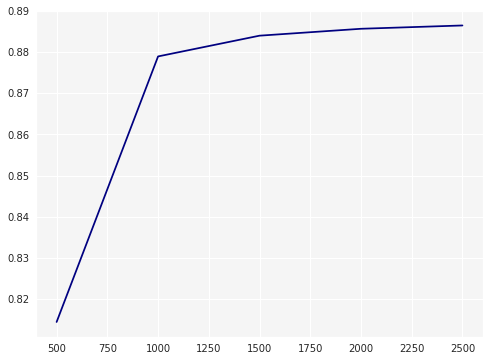

In [ ]:
print(XGB_gsearch.cv_results_['mean_test_score'])
ax=start_plot(figsize=(8,6));
ax.plot([500,1000,1500,2000,2500], XGB_gsearch.cv_results_['mean_test_score'][1:], color='navy');

看起來n_estimators=1000 or 1500就夠了，後面成長幅度太小。\
比較驚訝的是n_estimators=100的時候竟然是負值!

In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('PCA', PCA(n_components=138) ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        learning_rate= 0.01
                        ) ) ]) 

param_XGB2 = {
    'XGB__max_depth':[2,4,6,8],
    'XGB__min_child_weight':[5,6,7,8]
    }
XGB_gsearch2 = GridSearchCV(estimator=pipeline, param_grid=param_XGB2, scoring='r2', cv=5)
XGB_gsearch2.fit(X_train, y_train)

print('best scores:', XGB_gsearch2.best_score_)
print('best params:', XGB_gsearch2.best_params_)

best scores: 0.889534406910415
best params: {'XGB__max_depth': 4, 'XGB__min_child_weight': 6}
CPU times: user 21min 27s, sys: 21.6 s, total: 21min 48s
Wall time: 21min 30s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('PCA', PCA(n_components=138) ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        learning_rate= 0.01,
                        max_depth = 4,
                        min_child_weight = 6
                        ) ) ]) 

param_XGB3 = {
    'XGB__gamma':[0, 0.5, 1, 1.5, 2, 2.5] #剪枝
    }
XGB_gsearch3 = GridSearchCV(estimator=pipeline, param_grid=param_XGB3, scoring='r2', cv=5)
XGB_gsearch3.fit(X_train, y_train)

print('best scores:', XGB_gsearch3.best_score_)
print('best params:', XGB_gsearch3.best_params_)

best scores: 0.889534406910415
best params: {'XGB__gamma': 0}
CPU times: user 7min 3s, sys: 7.38 s, total: 7min 10s
Wall time: 7min 3s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('PCA', PCA(n_components=138) ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        learning_rate= 0.01,
                        max_depth = 4,
                        min_child_weight = 6,
                        gamma = 0
                        ) ) ]) 

param_XGB4 = {
    'XGB__subsample':[0.3,0.4,0.5,0.6],
    'XGB__colsample_bytree':[0.8,0.9,1]
    }
XGB_gsearch4 = GridSearchCV(estimator=pipeline, param_grid=param_XGB4, scoring='r2', cv=5)
XGB_gsearch4.fit(X_train, y_train)

print('best scores:', XGB_gsearch4.best_score_)
print('best params:', XGB_gsearch4.best_params_)

best scores: 0.8941447837491218
best params: {'XGB__colsample_bytree': 0.9, 'XGB__subsample': 0.4}
CPU times: user 9min 34s, sys: 15 s, total: 9min 49s
Wall time: 9min 35s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('PCA', PCA(n_components=138) ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        learning_rate= 0.01,
                        max_depth = 4,
                        min_child_weight = 6,
                        gamma = 0,
                        subsample = 0.4,
                        colsample_bytree = 0.9
                        ) ) ]) 

param_XGB5 = {
    'XGB__reg_lambda':[0.7, 0.8, 0.9, 1] #Regularization
    }
XGB_gsearch5 = GridSearchCV(estimator=pipeline, param_grid=param_XGB5, scoring='r2', cv=5)
XGB_gsearch5.fit(X_train, y_train)

print('best scores:', XGB_gsearch5.best_score_)
print('best params:', XGB_gsearch5.best_params_)

best scores: 0.8946705264553163
best params: {'XGB__reg_lambda': 0.8}
CPU times: user 3min 13s, sys: 5.27 s, total: 3min 18s
Wall time: 3min 13s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('PCA', PCA(n_components=138) ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        max_depth = 4,
                        min_child_weight = 6,
                        gamma = 0,
                        subsample = 0.4,
                        colsample_bytree = 0.9,
                        reg_lambda= 0.8
                        ) ) ]) 

param_XGB6 = {
    'XGB__learning_rate':[0.005, 0.01, 0.02, 0.03]
    }
XGB_gsearch6 = GridSearchCV(estimator=pipeline, param_grid=param_XGB6, scoring='r2', cv=5)
XGB_gsearch6.fit(X_train, y_train)

print('best scores:', XGB_gsearch6.best_score_)
print('best params:', XGB_gsearch6.best_params_)

best scores: 0.8946705264553163
best params: {'XGB__learning_rate': 0.01}
CPU times: user 3min 15s, sys: 5.37 s, total: 3min 20s
Wall time: 3min 15s


In [ ]:
%%time
N = len(train2.columns)-1 #原始成分數量
print(N)
scores_train = np.zeros(N)
scores_test = np.zeros(N)

for i in np.arange(N,2,-1): #從N遞減到2
    model = make_pipeline(
        RobustScaler(),
        PCA(n_components=i),
        XGBRegressor( objective='reg:squarederror',
                n_estimators = 1500,
                learning_rate = 0.01,
                max_depth = 4,
                min_child_weight = 6,
                gamma = 0,
                subsample = 0.4,
                colsample_bytree = 0.9,
                reg_lambda= 0.8
                        ) )
    model.fit(X_train,y_train)
    scores_train[i-1] = model.score(X_train,y_train) #也可以換成其他想用的score
    scores_test[i-1] = model.score(X_test,y_test)

xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(20,8));
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores');
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores');
ax.legend(loc='lower center',frameon=True,fontsize=13);

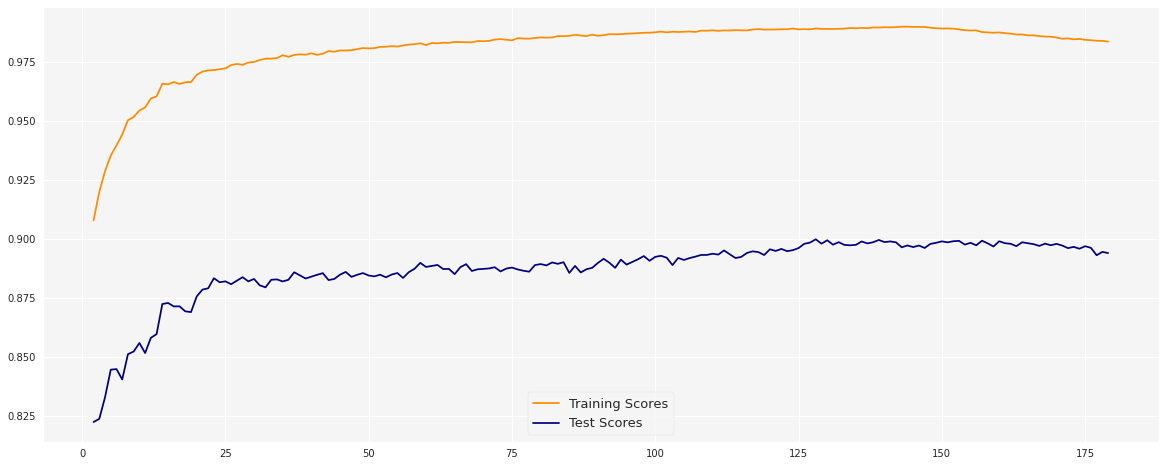

In [ ]:
xdomain = np.arange(2,N,1)
ax=start_plot(figsize=(20,8));
ax.plot(xdomain,scores_train[2:],color='darkorange',label='Training Scores');
ax.plot(xdomain,scores_test[2:],color='navy',label='Test Scores');
ax.legend(loc='lower center',frameon=True,fontsize=13);

In [ ]:
tmp = pd.DataFrame()
tmp['N'] = np.arange(0,N,1)
tmp['train'] = scores_train
tmp['test'] = scores_test
tmp.sort_values('test')

,N,train,test
0,0,0.000000,0.000000
1,1,0.000000,0.000000
2,2,0.907727,0.822332
3,3,0.919854,0.823680
4,4,0.928609,0.832809
...,...,...,...
153,153,0.988659,0.899081
157,157,0.987551,0.899156
130,130,0.988878,0.899350
139,139,0.989471,0.899473


### 10.2.2 建模

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = make_pipeline(RobustScaler(),
            PCA(n_components=128),
            XGBRegressor( objective='reg:squarederror',
                    n_estimators = 1500,
                    learning_rate = 0.01,
                    max_depth = 4,
                    min_child_weight = 6,
                    gamma = 0,
                    subsample = 0.4,
                    colsample_bytree = 0.9,
                    reg_lambda= 0.8
                    ) )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.8966183367455125
Root Mean Squared Logarithmic Error: 0.010010785680827033
 
5fold-CV R-squared: [0.89857896 0.89154158 0.88595939 0.90874615 0.89663382]
5fold-CV R-squared Avg: 0.8962919795067329
5fold-CV R-squared Std: 0.007612915097439642


怎麼調都很爛耶QQ 好像不用PCA還比較好

# 11 測試11 (Score: 0.13319)
Top 34%

## 11.2 Train資料嘗試建模

### 11.2.1 調整模型

In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        learning_rate= 0.01
                        ) ) ]) 

param_XGB = {
    'XGB__n_estimators':[100,500,1000,1500,2000,2500] #迭代次數太大會過於複雜
    }
XGB_gsearch = GridSearchCV(estimator=pipeline, param_grid=param_XGB, scoring='r2', cv=5)
XGB_gsearch.fit(X_train, y_train)

print('best scores:', XGB_gsearch.best_score_)
print('best params:', XGB_gsearch.best_params_)

best scores: 0.8997883303799827
best params: {'XGB__n_estimators': 2500}
CPU times: user 2min 24s, sys: 403 ms, total: 2min 24s
Wall time: 2min 24s


[-112.30299141    0.83845634    0.89683344    0.89973842    0.89975245
    0.89978833]


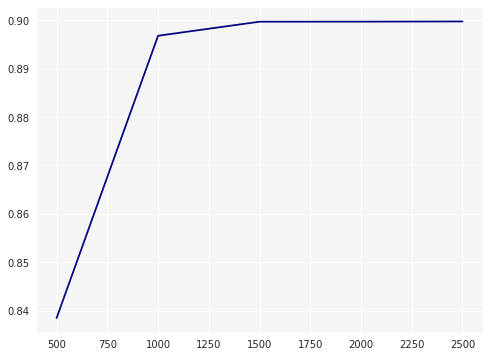

In [ ]:
print(XGB_gsearch.cv_results_['mean_test_score'])
ax=start_plot(figsize=(8,6));
ax.plot([500,1000,1500,2000,2500], XGB_gsearch.cv_results_['mean_test_score'][1:], color='navy');

In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        learning_rate= 0.01
                        ) ) ]) 

param_XGB2 = {
    'XGB__max_depth':[2,3,4,5],
    'XGB__min_child_weight':[7,8,9,10]
    }
XGB_gsearch2 = GridSearchCV(estimator=pipeline, param_grid=param_XGB2, scoring='r2', cv=5)
XGB_gsearch2.fit(X_train, y_train)

print('best scores:', XGB_gsearch2.best_score_)
print('best params:', XGB_gsearch2.best_params_)

best scores: 0.9035614088154554
best params: {'XGB__max_depth': 3, 'XGB__min_child_weight': 9}
CPU times: user 7min 52s, sys: 1.26 s, total: 7min 53s
Wall time: 7min 54s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        learning_rate= 0.01,
                        max_depth = 3,
                        min_child_weight = 9
                        ) ) ]) 

param_XGB3 = {
    'XGB__gamma':[0, 0.5, 1, 1.5, 2, 2.5] #剪枝
    }
XGB_gsearch3 = GridSearchCV(estimator=pipeline, param_grid=param_XGB3, scoring='r2', cv=5)
XGB_gsearch3.fit(X_train, y_train)

print('best scores:', XGB_gsearch3.best_score_)
print('best params:', XGB_gsearch3.best_params_)

best scores: 0.9035614088154554
best params: {'XGB__gamma': 0}
CPU times: user 2min 41s, sys: 395 ms, total: 2min 42s
Wall time: 2min 42s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        learning_rate= 0.01,
                        max_depth = 3,
                        min_child_weight = 9,
                        gamma = 0
                        ) ) ]) 

param_XGB4 = {
    'XGB__subsample':[0.5,0.6,0.7,0.8],
    'XGB__colsample_bytree':[0.8,0.9,1]
    }
XGB_gsearch4 = GridSearchCV(estimator=pipeline, param_grid=param_XGB4, scoring='r2', cv=5)
XGB_gsearch4.fit(X_train, y_train)

print('best scores:', XGB_gsearch4.best_score_)
print('best params:', XGB_gsearch4.best_params_)

best scores: 0.9070091392890486
best params: {'XGB__colsample_bytree': 0.9, 'XGB__subsample': 0.6}
CPU times: user 6min 8s, sys: 883 ms, total: 6min 9s
Wall time: 6min 10s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 1500,
                        learning_rate= 0.01,
                        max_depth = 3,
                        min_child_weight = 9,
                        gamma = 0,
                        subsample = 0.6,
                        colsample_bytree = 0.9
                        ) ) ])

param_XGB5 = {
    'XGB__reg_lambda':[0, 0.1, 0.25, 0.5, 0.75, 0.1], #Regularization
    'XGB__reg_alpha':[0, 0.1, 0.25, 0.5, 0.75, 0.1]
    }
XGB_gsearch5 = GridSearchCV(estimator=pipeline, param_grid=param_XGB5, scoring='r2', cv=5)
XGB_gsearch5.fit(X_train, y_train)

print('best scores:', XGB_gsearch5.best_score_)
print('best params:', XGB_gsearch5.best_params_)

best scores: 0.907857645625967
best params: {'XGB__reg_alpha': 0.1, 'XGB__reg_lambda': 0}
CPU times: user 19min 9s, sys: 2.93 s, total: 19min 12s
Wall time: 19min 14s


### 11.2.2 建模

和測試7比較


```
R-squared: 0.9183935038636898
Root Mean Squared Logarithmic Error: 0.008872607680071367
 
5fold-CV R-squared: [0.91811468 0.92452649 0.9039674  0.91980978 0.90778994]
5fold-CV R-squared Avg: 0.9148416582463256
5fold-CV R-squared Std: 0.007709306128002867
```



#### n_estimators=1500, 0.9118

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 1500, 
            learning_rate = 0.01,
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9079167038087845
Root Mean Squared Logarithmic Error: 0.009517554003933627
 
5fold-CV R-squared: [0.91866429 0.91398425 0.90057861 0.91235709 0.91331204]
5fold-CV R-squared Avg: 0.9117792550462948
5fold-CV R-squared Std: 0.006006720985301986


#### n_estimators=2000, 0.9123

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2000, #微調看看
            learning_rate = 0.01,
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9086436513704015
Root Mean Squared Logarithmic Error: 0.009483693249322241
 
5fold-CV R-squared: [0.91908238 0.91329392 0.90062974 0.91425356 0.9140547 ]
5fold-CV R-squared Avg: 0.9122628586190424
5fold-CV R-squared Std: 0.006165583023081229


#### n_estimators=2500, 0.9127

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2500, #微調看看
            learning_rate = 0.01,
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9086078850084384
Root Mean Squared Logarithmic Error: 0.009485831505554368
 
5fold-CV R-squared: [0.91944567 0.91299292 0.90057141 0.91569255 0.91470535]
5fold-CV R-squared Avg: 0.9126815788521853
5fold-CV R-squared Std: 0.006413542804822461


#### n_estimators=3000, 0.9124

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 3000, #微調看看
            learning_rate = 0.01,
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9084358570123927
Root Mean Squared Logarithmic Error: 0.009496876678498946
 
5fold-CV R-squared: [0.91902928 0.91255623 0.90002361 0.91605485 0.91415707]
5fold-CV R-squared Avg: 0.9123642077432244
5fold-CV R-squared Std: 0.0065358333419158286


#### n_estimators=2750, 0.9125

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2750, #微調看看
            learning_rate = 0.01,
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9084235853529896
Root Mean Squared Logarithmic Error: 0.009496844553156874
 
5fold-CV R-squared: [0.9192735  0.91282045 0.90028336 0.91581656 0.91424543]
5fold-CV R-squared Avg: 0.9124878613313235
5fold-CV R-squared Std: 0.00646953706173552


#### n_estimators=2600, 0.9125

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2600, #微調看看
            learning_rate = 0.01,
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9087548443098422
Root Mean Squared Logarithmic Error: 0.009478952078080242
 
5fold-CV R-squared: [0.91938743 0.91281944 0.90051839 0.91558142 0.91444048]
5fold-CV R-squared Avg: 0.9125494328394907
5fold-CV R-squared Std: 0.006392903594405023


#### n_estimators=2550, 0.9125

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2550, #微調看看
            learning_rate = 0.01,
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.908689202187916
Root Mean Squared Logarithmic Error: 0.00948164667839101
 
5fold-CV R-squared: [0.91935628 0.91287703 0.90066468 0.91568569 0.91454015]
5fold-CV R-squared Avg: 0.9126247659209603
5fold-CV R-squared Std: 0.006347574753664535


#### learning_rate

In [ ]:
XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2500,
            learning_rate = 0.009, #微調看看
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9097430860443384
Root Mean Squared Logarithmic Error: 0.00942449031299914
 
5fold-CV R-squared: [0.91919059 0.91209448 0.90151381 0.91590918 0.91469182]
5fold-CV R-squared Avg: 0.912679975243727
5fold-CV R-squared Std: 0.006031408611673452


In [ ]:
XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2500,
            learning_rate = 0.008, #微調看看
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9093605758878761
Root Mean Squared Logarithmic Error: 0.00944754676365189
 
5fold-CV R-squared: [0.91957897 0.91286906 0.90242838 0.91561885 0.91388519]
5fold-CV R-squared Avg: 0.9128760903913411
5fold-CV R-squared Std: 0.005703054994135886


結果又換成StandardScaler

In [ ]:
XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2500,
            learning_rate = 0.008, #微調看看
            max_depth = 3,
            min_child_weight = 9,
            gamma = 0,
            subsample = 0.6,
            colsample_bytree = 0.9,
            reg_lambda= 0,
            reg_alpha= 0.1 
            )
model = make_pipeline(StandardScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9090844647422427
Root Mean Squared Logarithmic Error: 0.009461586673656156
 
5fold-CV R-squared: [0.91990942 0.91296308 0.90258168 0.91547883 0.91418484]
5fold-CV R-squared Avg: 0.913023571916438
5fold-CV R-squared Std: 0.005724132348677039


### 11.2.3 GridSearchCV again

In [ ]:
%%time
pipeline = Pipeline([ ('StandardScaler', StandardScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 2500,
                        learning_rate= 0.008
                        ) ) ]) 

param_XGB = {
    'XGB__max_depth':[3,4,5,6,7],
    'XGB__min_child_weight':[3,4,5,6,7]
    }
XGB_gsearch = GridSearchCV(estimator=pipeline, param_grid=param_XGB, scoring='r2', cv=5, verbose=10)
XGB_gsearch.fit(X_train, y_train)

print('best scores:', XGB_gsearch.best_score_)
print('best params:', XGB_gsearch.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] XGB__max_depth=3, XGB__min_child_weight=3 .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  XGB__max_depth=3, XGB__min_child_weight=3, score=0.883, total=   9.4s
[CV] XGB__max_depth=3, XGB__min_child_weight=3 .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=3, score=0.919, total=   9.0s
[CV] XGB__max_depth=3, XGB__min_child_weight=3 .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.4s remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=3, score=0.910, total=   9.0s
[CV] XGB__max_depth=3, XGB__min_child_weight=3 .......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.4s remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=3, score=0.895, total=   9.2s
[CV] XGB__max_depth=3, XGB__min_child_weight=3 .......................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.6s remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=3, score=0.910, total=   9.1s
[CV] XGB__max_depth=3, XGB__min_child_weight=4 .......................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.7s remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=4, score=0.883, total=   9.2s
[CV] XGB__max_depth=3, XGB__min_child_weight=4 .......................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   54.9s remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=4, score=0.916, total=   9.1s
[CV] XGB__max_depth=3, XGB__min_child_weight=4 .......................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=4, score=0.908, total=   9.1s
[CV] XGB__max_depth=3, XGB__min_child_weight=4 .......................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=4, score=0.894, total=   9.8s
[CV] XGB__max_depth=3, XGB__min_child_weight=4 .......................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV]  XGB__max_depth=3, XGB__min_child_weight=4, score=0.912, total=   9.2s
[CV] XGB__max_depth=3, XGB__min_child_weight=5 .......................
[CV]  XGB__max_depth=3, XGB__min_child_weight=5, score=0.884, total=   9.0s
[CV] XGB__max_depth=3, XGB__min_child_weight=5 .......................
[CV]  XGB__max_depth=3, XGB__min_child_weight=5, score=0.916, total=   9.2s
[CV] XGB__max_depth=3, XGB__min_child_weight=5 .......................
[CV]  XGB__max_depth=3, XGB__min_child_weight=5, score=0.909, total=   9.1s
[CV] XGB__max_depth=3, XGB__min_child_weight=5 .......................
[CV]  XGB__max_depth=3, XGB__min_child_weight=5, score=0.890, total=   9.1s
[CV] XGB__max_depth=3, XGB__min_child_weight=5 .......................
[CV]  XGB__max_depth=3, XGB__min_child_weight=5, score=0.908, total=   9.0s
[CV] XGB__max_depth=3, XGB__min_child_weight=6 .......................
[CV]  XGB__max_depth=3, XGB__min_child_weight=6, score=0.883, total=   9.1s
[CV] XGB__max_depth=3, XGB__min_child_weig

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 28.7min finished


best scores: 0.9033677910641739
best params: {'XGB__max_depth': 3, 'XGB__min_child_weight': 3}
CPU times: user 28min 41s, sys: 5.54 s, total: 28min 47s
Wall time: 28min 54s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 2500,
                        learning_rate= 0.008,
                        max_depth = 3,
                        min_child_weight = 3
                        ) ) ]) 

param_XGB2 = {
    'XGB__gamma':[0, 0.5, 1, 1.5, 2, 2.5] #剪枝
    }
XGB_gsearch2 = GridSearchCV(estimator=pipeline, param_grid=param_XGB2, scoring='r2', cv=5, verbose=10)
XGB_gsearch2.fit(X_train, y_train)

print('best scores:', XGB_gsearch2.best_score_)
print('best params:', XGB_gsearch2.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] XGB__gamma=0 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ XGB__gamma=0, score=0.883, total=   9.7s
[CV] XGB__gamma=0 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV] ........................ XGB__gamma=0, score=0.919, total=   9.1s
[CV] XGB__gamma=0 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.8s remaining:    0.0s


[CV] ........................ XGB__gamma=0, score=0.910, total=   8.9s
[CV] XGB__gamma=0 ....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s


[CV] ........................ XGB__gamma=0, score=0.895, total=   9.0s
[CV] XGB__gamma=0 ....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.7s remaining:    0.0s


[CV] ........................ XGB__gamma=0, score=0.910, total=   9.2s
[CV] XGB__gamma=0.5 ..................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   45.9s remaining:    0.0s


[CV] ...................... XGB__gamma=0.5, score=0.845, total=   9.4s
[CV] XGB__gamma=0.5 ..................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   55.3s remaining:    0.0s


[CV] ...................... XGB__gamma=0.5, score=0.869, total=   9.8s
[CV] XGB__gamma=0.5 ..................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV] ...................... XGB__gamma=0.5, score=0.865, total=   9.1s
[CV] XGB__gamma=0.5 ..................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[CV] ...................... XGB__gamma=0.5, score=0.862, total=   9.0s
[CV] XGB__gamma=0.5 ..................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV] ...................... XGB__gamma=0.5, score=0.876, total=   8.9s
[CV] XGB__gamma=1 ....................................................
[CV] ........................ XGB__gamma=1, score=0.824, total=   8.9s
[CV] XGB__gamma=1 ....................................................
[CV] ........................ XGB__gamma=1, score=0.846, total=   9.1s
[CV] XGB__gamma=1 ....................................................
[CV] ........................ XGB__gamma=1, score=0.836, total=   8.9s
[CV] XGB__gamma=1 ....................................................
[CV] ........................ XGB__gamma=1, score=0.841, total=   9.0s
[CV] XGB__gamma=1 ....................................................
[CV] ........................ XGB__gamma=1, score=0.854, total=   8.9s
[CV] XGB__gamma=1.5 ..................................................
[CV] ...................... XGB__gamma=1.5, score=0.807, total=   8.9s
[CV] XGB__gamma=1.5 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.5min finished


best scores: 0.903405640015347
best params: {'XGB__gamma': 0}
CPU times: user 4min 40s, sys: 856 ms, total: 4min 41s
Wall time: 4min 42s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 2500,
                        learning_rate= 0.008,
                        max_depth = 3,
                        min_child_weight = 3,
                        gamma = 0
                        ) ) ]) 

param_XGB3 = {
    'XGB__subsample':[0.3, 0.4, 0.5, 0.6],
    'XGB__colsample_bytree':[0.6, 0.7, 0.8, 0.9]
    }
XGB_gsearch3 = GridSearchCV(estimator=pipeline, param_grid=param_XGB3, scoring='r2', cv=5, verbose=10)
XGB_gsearch3.fit(X_train, y_train)

print('best scores:', XGB_gsearch3.best_score_)
print('best params:', XGB_gsearch3.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.3 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.3, score=0.888, total=   6.8s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.3 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.3, score=0.919, total=   6.7s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.3 ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.3, score=0.908, total=   6.8s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.3 ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.3s remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.3, score=0.902, total=   6.8s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.3 ...................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.1s remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.3, score=0.927, total=   6.9s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.4 ...................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.0s remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.4, score=0.888, total=   7.6s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.4 ...................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   41.5s remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.4, score=0.921, total=   7.6s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.4 ...................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   49.1s remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.4, score=0.907, total=   7.6s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.4 ...................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   56.7s remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.4, score=0.902, total=   7.6s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.4 ...................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.4, score=0.926, total=   7.6s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.5 ...................
[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.5, score=0.886, total=   8.0s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.5 ...................
[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.5, score=0.921, total=   8.1s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.5 ...................
[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.5, score=0.907, total=   8.2s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.5 ...................
[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.5, score=0.905, total=   8.2s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.5 ...................
[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.5, score=0.926, total=   8.0s
[CV] XGB__colsample_bytree=0.6, XGB__subsample=0.6 ...................
[CV]  XGB__colsample_bytree=0.6, XGB__subsample=0.6, score=0.887, total=   7.9s
[CV] XGB__cols

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 11.9min finished


best scores: 0.909433148901333
best params: {'XGB__colsample_bytree': 0.8, 'XGB__subsample': 0.5}
CPU times: user 12min 1s, sys: 2.09 s, total: 12min 3s
Wall time: 12min 5s


In [ ]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('XGB', XGBRegressor( objective='reg:squarederror',
                        n_estimators = 2500,
                        learning_rate= 0.008,
                        max_depth = 3,
                        min_child_weight = 3,
                        gamma = 0,
                        subsample = 0.5,
                        colsample_bytree = 0.8
                        ) ) ]) 

param_XGB4 = {
    'XGB__reg_lambda':[0, 0.1, 0.25, 0.5, 0.75, 0.1], #Regularization
    'XGB__reg_alpha':[0, 0.1, 0.25, 0.5, 0.75, 0.1]
    }
XGB_gsearch4 = GridSearchCV(estimator=pipeline, param_grid=param_XGB4, scoring='r2', cv=5, verbose=10)
XGB_gsearch4.fit(X_train, y_train)

print('best scores:', XGB_gsearch4.best_score_)
print('best params:', XGB_gsearch4.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . XGB__reg_alpha=0, XGB__reg_lambda=0, score=0.889, total=  10.4s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] . XGB__reg_alpha=0, XGB__reg_lambda=0, score=0.918, total=  10.2s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s


[CV] . XGB__reg_alpha=0, XGB__reg_lambda=0, score=0.907, total=  10.2s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0 .............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.7s remaining:    0.0s


[CV] . XGB__reg_alpha=0, XGB__reg_lambda=0, score=0.904, total=  10.3s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0 .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   41.0s remaining:    0.0s


[CV] . XGB__reg_alpha=0, XGB__reg_lambda=0, score=0.920, total=  10.3s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.1 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.3s remaining:    0.0s


[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.1, score=0.889, total=  10.4s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.1 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.1, score=0.920, total=  10.2s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.1 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.1, score=0.907, total=  10.5s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.1 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.1, score=0.906, total=  10.7s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.1 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.1, score=0.922, total=  10.3s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.25 ..........................
[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.25, score=0.887, total=  10.1s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.25 ..........................
[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.25, score=0.921, total=  10.3s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.25 ..........................
[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.25, score=0.908, total=  10.1s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.25 ..........................
[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.25, score=0.906, total=  10.1s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.25 ..........................
[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.25, score=0.923, total=  10.0s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.5 ...........................
[CV]  XGB__reg_alpha=0, XGB__reg_lambda=0.5, score=0.885, total=   9.9s
[CV] XGB__reg_alpha=0, XGB__reg_lambda=0.5 ......................

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 30.2min finished


best scores: 0.909162620053556
best params: {'XGB__reg_alpha': 0.1, 'XGB__reg_lambda': 0.75}
CPU times: user 30min 15s, sys: 5.13 s, total: 30min 20s
Wall time: 30min 27s


### 11.2.4 建模 again

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2500,
            learning_rate= 0.008,
            max_depth = 3,
            min_child_weight = 3,
            gamma = 0,
            subsample = 0.5,
            colsample_bytree = 0.8,
            reg_lambda= 0.75,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9153854441841005
Root Mean Squared Logarithmic Error: 0.0090844573224355
 
5fold-CV R-squared: [0.92501522 0.91709755 0.90438266 0.92076895 0.91230952]
5fold-CV R-squared Avg: 0.9159147807941151
5fold-CV R-squared Std: 0.0071241525164725


這次好像可以!

### 11.2.5 預測
最後是Top 34%，只進步2%嗚嗚

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2500,
            learning_rate= 0.008,
            max_depth = 3,
            min_child_weight = 3,
            gamma = 0,
            subsample = 0.5,
            colsample_bytree = 0.8,
            reg_lambda= 0.75,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)

submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,129133.546875
1,1462,159458.640625
2,1463,184404.578125
3,1464,190582.343750
4,1465,190941.125000


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/RobustScaler_XGBoost.csv',index=False)

# 12 測試12 (Score: 0.13412)

分數反而下降了XD

In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 3300,
            learning_rate= 0.008,
            max_depth = 3,
            min_child_weight = 3,
            gamma = 0,
            subsample = 0.5,
            colsample_bytree = 0.8,
            reg_lambda= 0.75,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9157626493213464
Root Mean Squared Logarithmic Error: 0.009063716442132596
 
5fold-CV R-squared: [0.92555688 0.91756704 0.90495234 0.92218373 0.91311775]
5fold-CV R-squared Avg: 0.9166755494400493
5fold-CV R-squared Std: 0.007212549856444333


In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 3300,
            learning_rate= 0.009,
            max_depth = 3,
            min_child_weight = 3,
            gamma = 0,
            subsample = 0.5,
            colsample_bytree = 0.8,
            reg_lambda= 0.75,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.914647763603467
Root Mean Squared Logarithmic Error: 0.009124505911209701
 
5fold-CV R-squared: [0.92595039 0.91901652 0.90560503 0.92408888 0.91323419]
5fold-CV R-squared Avg: 0.9175790042304266
5fold-CV R-squared Std: 0.0074401414169360065


In [ ]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 3300,
            learning_rate= 0.009,
            max_depth = 3,
            min_child_weight = 3,
            gamma = 0,
            subsample = 0.5,
            colsample_bytree = 0.8,
            reg_lambda= 0.75,
            reg_alpha= 0.1 
            )
model = make_pipeline(RobustScaler(), XGBoost )
model.fit(X, y)
y_pred = model.predict(X_realtest)
y_pred = np.exp(y_pred)

submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,130484.632812
1,1462,160084.281250
2,1463,185269.750000
3,1464,190911.625000
4,1465,188008.625000


In [ ]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/RobustScaler_XGBoost2.csv',index=False)

# 13 測試13 (Score: 0.13120)
TOP 29%

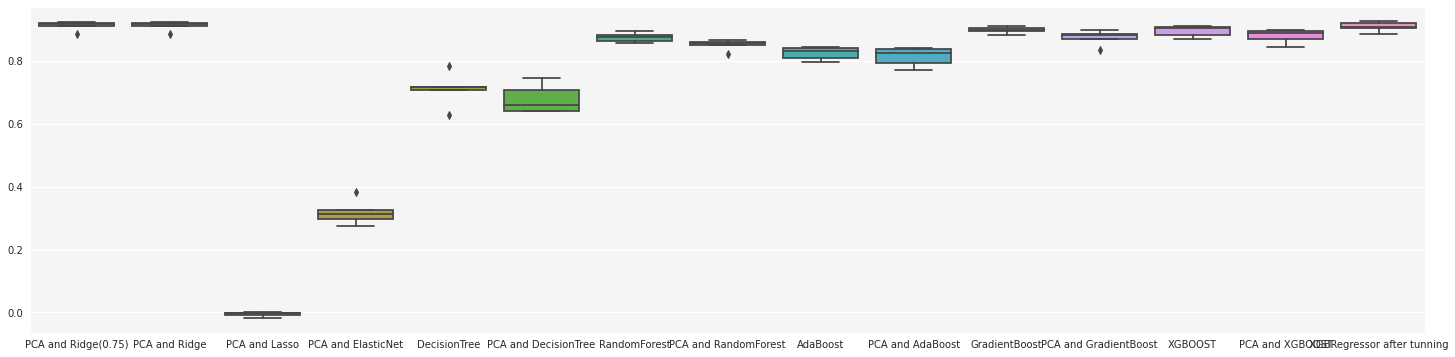

In [ ]:
model_1 = make_pipeline( RobustScaler(),PCA(n_components=145),Ridge(alpha=0.75) )
model_2 = make_pipeline( RobustScaler(),PCA(n_components=145),Ridge() )
model_3 = make_pipeline( RobustScaler(),PCA(n_components=145),Lasso() )
model_4 = make_pipeline( RobustScaler(),PCA(n_components=145),ElasticNet() )
model_5 = make_pipeline( RobustScaler(),DecisionTreeRegressor() )
model_6 = make_pipeline( RobustScaler(),PCA(n_components=145),DecisionTreeRegressor() )
model_7 = make_pipeline( RobustScaler(),RandomForestRegressor() )
model_8 = make_pipeline( RobustScaler(),PCA(n_components=145),RandomForestRegressor() )
model_9 = make_pipeline( RobustScaler(),AdaBoostRegressor() )
model_10 = make_pipeline( RobustScaler(),PCA(n_components=145),AdaBoostRegressor() )
model_11 = make_pipeline( RobustScaler(),GradientBoostingRegressor() )
model_12 = make_pipeline( RobustScaler(),PCA(n_components=145),GradientBoostingRegressor() )
model_13 = make_pipeline( RobustScaler(),XGBRegressor(objective='reg:squarederror') )
model_14 = make_pipeline( RobustScaler(),PCA(n_components=145),XGBRegressor(objective='reg:squarederror') )
model_15 = make_pipeline( RobustScaler(), XGBRegressor( objective='reg:squarederror',
                                n_estimators = 2500,
                                learning_rate= 0.008,
                                max_depth = 3,
                                min_child_weight = 3,
                                gamma = 0,
                                subsample = 0.5,
                                colsample_bytree = 0.8,
                                reg_lambda= 0.75,
                                reg_alpha= 0.1 
                                ) )


models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8,
          model_9, model_10, model_11, model_12, model_13, model_14, model_15]
titles = ['PCA and Ridge(0.75)',  'PCA and Ridge', 'PCA and Lasso', 'PCA and ElasticNet',
          'DecisionTree', 'PCA and DecisionTree',
          'RandomForest', 'PCA and RandomForest',
          'AdaBoost', 'PCA and AdaBoost',
          'GradientBoost', 'PCA and GradientBoost',
          'XGBOOST', 'PCA and XGBOOST', 'XGBRegressor after tunning']

model_comp = pd.DataFrame()
cv = StratifiedKFold(n_splits=5)

for i, model in enumerate(models):
    model_comp[titles[i]] = cross_val_score(model, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(25,6));
sns.boxplot(data=model_comp, ax=ax);

看起來就 PCA+Ridge、GradientBoost、XGBoost比較好

In [ ]:
model_comp.describe()['mean':'mean']

,PCA and Ridge(0.75),PCA and Ridge,PCA and Lasso,PCA and ElasticNet,DecisionTree,PCA and DecisionTree,RandomForest,PCA and RandomForest,AdaBoost,PCA and AdaBoost,GradientBoost,PCA and GradientBoost,XGBOOST,PCA and XGBOOST,XGBRegressor after tunning
mean,0.910948,0.911867,-0.005648,0.318482,0.7102,0.67884,0.874476,0.850447,0.823982,0.813462,0.897741,0.874237,0.895325,0.878618,0.909163


## 調整GradientBoost

In [21]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('GB', GradientBoostingRegressor() ) ]) 

param_GB = {
    'GB__n_estimators':[400,500,600,650,700],
    'GB__learning_rate':[0.01, 0.02, 0.025, 0.03, 0.04]
    }
GB_gsearch = GridSearchCV(estimator=pipeline, param_grid=param_GB, scoring='r2', cv=5)
GB_gsearch.fit(X_train, y_train)

print('best scores:', GB_gsearch.best_score_)
print('best params:', GB_gsearch.best_params_)

best scores: 0.8995854496987625
best params: {'GB__learning_rate': 0.025, 'GB__n_estimators': 650}
CPU times: user 7min 8s, sys: 151 ms, total: 7min 9s
Wall time: 7min 12s


In [25]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('GB', GradientBoostingRegressor( n_estimators = 650,
                                learning_rate = 0.025) ) ]) 

param_GB2 = {
    'GB__max_depth':[4,5,6],
    'GB__min_samples_split':[2,100,200,300,400,500]
    }
GB_gsearch2 = GridSearchCV(estimator=pipeline, param_grid=param_GB2, scoring='r2', cv=5)
GB_gsearch2.fit(X_train, y_train)

print('best scores:', GB_gsearch2.best_score_)
print('best params:', GB_gsearch2.best_params_)

best scores: 0.9035710316541316
best params: {'GB__max_depth': 5, 'GB__min_samples_split': 400}
CPU times: user 9min 23s, sys: 207 ms, total: 9min 24s
Wall time: 9min 30s


In [30]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('GB', GradientBoostingRegressor( n_estimators = 650,
                                learning_rate = 0.025,
                                max_depth = 5) ) ]) 

param_GB3 = {
    'GB__min_samples_leaf':[7,8,9,10],
    'GB__min_samples_split':[340,350,360,370,380]
    }
GB_gsearch3 = GridSearchCV(estimator=pipeline, param_grid=param_GB3, scoring='r2', cv=5)
GB_gsearch3.fit(X_train, y_train)

print('best scores:', GB_gsearch3.best_score_)
print('best params:', GB_gsearch3.best_params_)

best scores: 0.9057780436550228
best params: {'GB__min_samples_leaf': 9, 'GB__min_samples_split': 360}
CPU times: user 9min 6s, sys: 133 ms, total: 9min 6s
Wall time: 9min 9s


In [32]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('GB', GradientBoostingRegressor( n_estimators = 650,
                                learning_rate = 0.025,
                                max_depth = 5,
                                min_samples_leaf = 9,
                                min_samples_split = 360) ) ]) 

param_GB4 = {
    'GB__subsample':[0.8,0.9,1]
    }
GB_gsearch4 = GridSearchCV(estimator=pipeline, param_grid=param_GB4, scoring='r2', cv=5)
GB_gsearch4.fit(X_train, y_train)

print('best scores:', GB_gsearch4.best_score_)
print('best params:', GB_gsearch4.best_params_)

best scores: 0.9057184921863353
best params: {'GB__subsample': 1}
CPU times: user 1min 18s, sys: 18.7 ms, total: 1min 18s
Wall time: 1min 18s


In [37]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('GB', GradientBoostingRegressor( n_estimators = 650,
                                learning_rate = 0.025,
                                max_depth = 5,
                                min_samples_leaf = 9,
                                min_samples_split = 360,
                                subsample = 1) ) ]) 

param_GB5 = {
    'GB__max_features':[113,114,115,116,117,118,119,120]
    }
GB_gsearch5 = GridSearchCV(estimator=pipeline, param_grid=param_GB5, scoring='r2', cv=5)
GB_gsearch5.fit(X_train, y_train)

print('best scores:', GB_gsearch5.best_score_)
print('best params:', GB_gsearch5.best_params_)

best scores: 0.906389040806857
best params: {'GB__max_features': 119}
CPU times: user 2min 33s, sys: 59.3 ms, total: 2min 33s
Wall time: 2min 34s


In [42]:
%%time
pipeline = Pipeline([ ('RobustScaler', RobustScaler() ),
            ('GB', GradientBoostingRegressor( max_depth = 5,
                                min_samples_leaf = 9,
                                min_samples_split = 360,
                                subsample = 1,
                                max_features = 119) ) ]) 

param_GB6 = {
    'GB__n_estimators':[650,800,1000,1500,2000,2500],
    'GB__learning_rate':[0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
    }
GB_gsearch6 = GridSearchCV(estimator=pipeline, param_grid=param_GB6, scoring='r2', cv=5)
GB_gsearch6.fit(X_train, y_train)

print('best scores:', GB_gsearch6.best_score_)
print('best params:', GB_gsearch6.best_params_)

best scores: 0.9064512860415779
best params: {'GB__learning_rate': 0.015, 'GB__n_estimators': 1500}
CPU times: user 25min 3s, sys: 429 ms, total: 25min 3s
Wall time: 25min 16s


In [43]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

GBoost = GradientBoostingRegressor( n_estimators = 1500,
                    learning_rate = 0.015,
                    max_depth = 5,
                    min_samples_leaf = 9,
                    min_samples_split = 360,
                    subsample = 1,
                    max_features = 119)
model = make_pipeline(RobustScaler(), GBoost )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('R-squared:',model.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(model, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9047174151118753
Root Mean Squared Logarithmic Error: 0.00967903031429976
 
5fold-CV R-squared: [0.91190802 0.90592576 0.89842378 0.90329882 0.91059367]
5fold-CV R-squared Avg: 0.9060300131344677
5fold-CV R-squared Std: 0.004913308996346016


## Ensemble

In [44]:
%%time
from sklearn.ensemble import VotingRegressor

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2500,
            learning_rate= 0.008,
            max_depth = 3,
            min_child_weight = 3,
            gamma = 0,
            subsample = 0.5,
            colsample_bytree = 0.8,
            reg_lambda= 0.75,
            reg_alpha= 0.1 
            )

GBoost = GradientBoostingRegressor( n_estimators = 1500,
                    learning_rate = 0.015,
                    max_depth = 5,
                    min_samples_leaf = 9,
                    min_samples_split = 360,
                    subsample = 1,
                    max_features = 119)

model_1 = make_pipeline( RobustScaler(),PCA(n_components=145),Ridge(alpha=0.75) )
model_2 = make_pipeline( RobustScaler(), XGBoost )
model_3 = make_pipeline( RobustScaler(), GBoost )

ensemblemodel = VotingRegressor( estimators = [ ('Ridge', model_1),
                            ('XGBoost', model_2),
                            ('GB', model_3)])
ensemblemodel.fit(X_train, y_train)
y_pred = ensemblemodel.predict(X_test)

print('R-squared:',ensemblemodel.score(X_test, y_test))
print('Root Mean Squared Logarithmic Error:', rmsle(y_test, y_pred))
print(' ')
cv_results = cross_val_score(ensemblemodel, X, y, cv=5)
print('5fold-CV R-squared:',cv_results)
print('5fold-CV R-squared Avg:',np.average(cv_results))
print('5fold-CV R-squared Std:',np.std(cv_results))

R-squared: 0.9203164775876637
Root Mean Squared Logarithmic Error: 0.008827126753438982
 
5fold-CV R-squared: [0.92683987 0.92441879 0.90907502 0.92154608 0.91771302]
5fold-CV R-squared Avg: 0.9199185558439644
5fold-CV R-squared Std: 0.006216948276908455
CPU times: user 2min 42s, sys: 1.73 s, total: 2min 44s
Wall time: 2min 43s


In [45]:
X = train2.drop('SalePrice_log', axis = 1).values
y = train2['SalePrice_log'].values

XGBoost = XGBRegressor( objective='reg:squarederror',
            n_estimators = 2500,
            learning_rate= 0.008,
            max_depth = 3,
            min_child_weight = 3,
            gamma = 0,
            subsample = 0.5,
            colsample_bytree = 0.8,
            reg_lambda= 0.75,
            reg_alpha= 0.1 
            )

GBoost = GradientBoostingRegressor( n_estimators = 1500,
                    learning_rate = 0.015,
                    max_depth = 5,
                    min_samples_leaf = 9,
                    min_samples_split = 360,
                    subsample = 1,
                    max_features = 119)

model_1 = make_pipeline( RobustScaler(),PCA(n_components=145),Ridge(alpha=0.75) )
model_2 = make_pipeline(RobustScaler(), XGBoost )
model_3 = make_pipeline(RobustScaler(), GBoost )

ensemblemodel = VotingRegressor( estimators = [ ('Ridge', model_1),
                            ('XGBoost', model_2),
                            ('GB', model_3)])

ensemblemodel.fit(X, y)
y_pred = ensemblemodel.predict(X_realtest)
y_pred = np.exp(y_pred)

submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_pred
submit.head()

,Id,SalePrice
0,1461,129429.474276
1,1462,157196.514804
2,1463,184142.494393
3,1464,194834.613425
4,1465,195538.684174


In [46]:
submit.to_csv('/content/drive/My Drive/kaggle/house_prices_advanced_regression_techniques/Ensemble.csv',index=False)